# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 04.11.2022

Мягкий дедлайн: 23:59MSK 16.11.2022

Жесткий дедлайн: 23:59MSK 23.11.2022

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей

In [9]:
# !pip install --upgrade scikit-learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm.notebook import tqdm
from typing import List

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = 20, 8
plt.rcParams['font.size'] = 18
plt.rcParams['axes.titlepad'] = 25
mpl.rcParams['savefig.format'] = 'pdf'
plt.style.use('ggplot') # мне просто привычнее с этим

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт один из двух классов с равными вероятностями. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [4]:
np.random.seed(42)

# наш случайный классификатор
y_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])
y_random

array([0, 1, 1, ..., 0, 0, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно, за особенно эффективные или красивые варианты может быть начислен небольшой бонус :)

In [5]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

AUC-PR: 0.63340
AUC-ROC: 0.50394


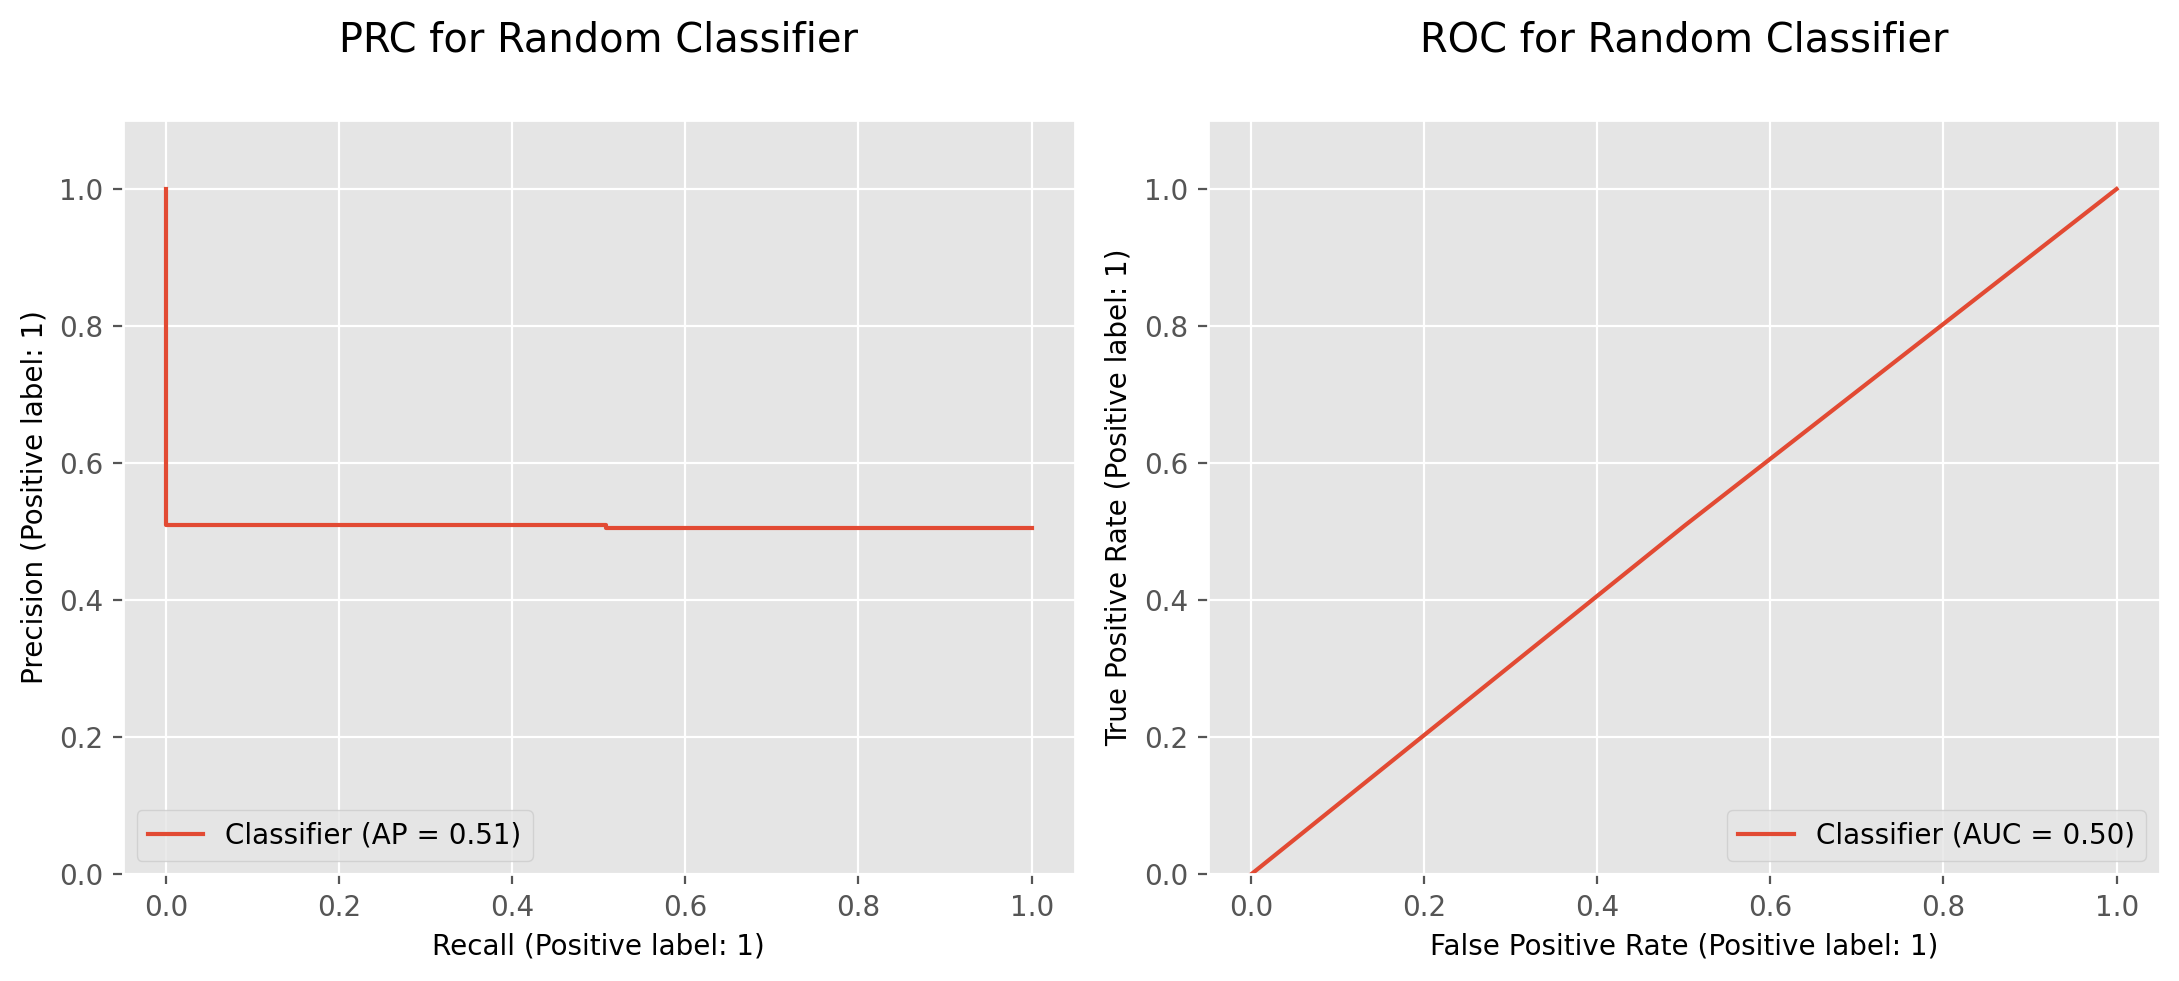

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_random)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_random))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)

plt.tight_layout()

In [7]:
def plot_prc_roc(y_pred: np.array, 
                 y_test: np.array,
                 classifier: str
                ):
    
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax[0])
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    auc_ = round(auc(recall, precision), 5)
    print(f'AUC-PR: {auc_}')
    ax[0].set_title("PRC for Random Classifier")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax[1])
    roc_auc_score_ = round(roc_auc_score(y_test, y_pred), 5)
    print(f'AUC-ROC: {roc_auc_score_}')
    ax[1].set_title(f'ROC for {classifier}')
    ax[1].set_ylim(0, 1.1)
    plt.tight_layout()
    
    return auc_, roc_auc_score_

In [8]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_random),
    None
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

__NB!__ Здесь и далее, если не сказано иначе, подбирайте __оптимальные гиперпараметры с точки зрения AUC-PR.__

Поделим на обучающую / тестовую выборку

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression

In [10]:
#your code here

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучим `SVC`

In [11]:
rs=42

Best C = 0.0005


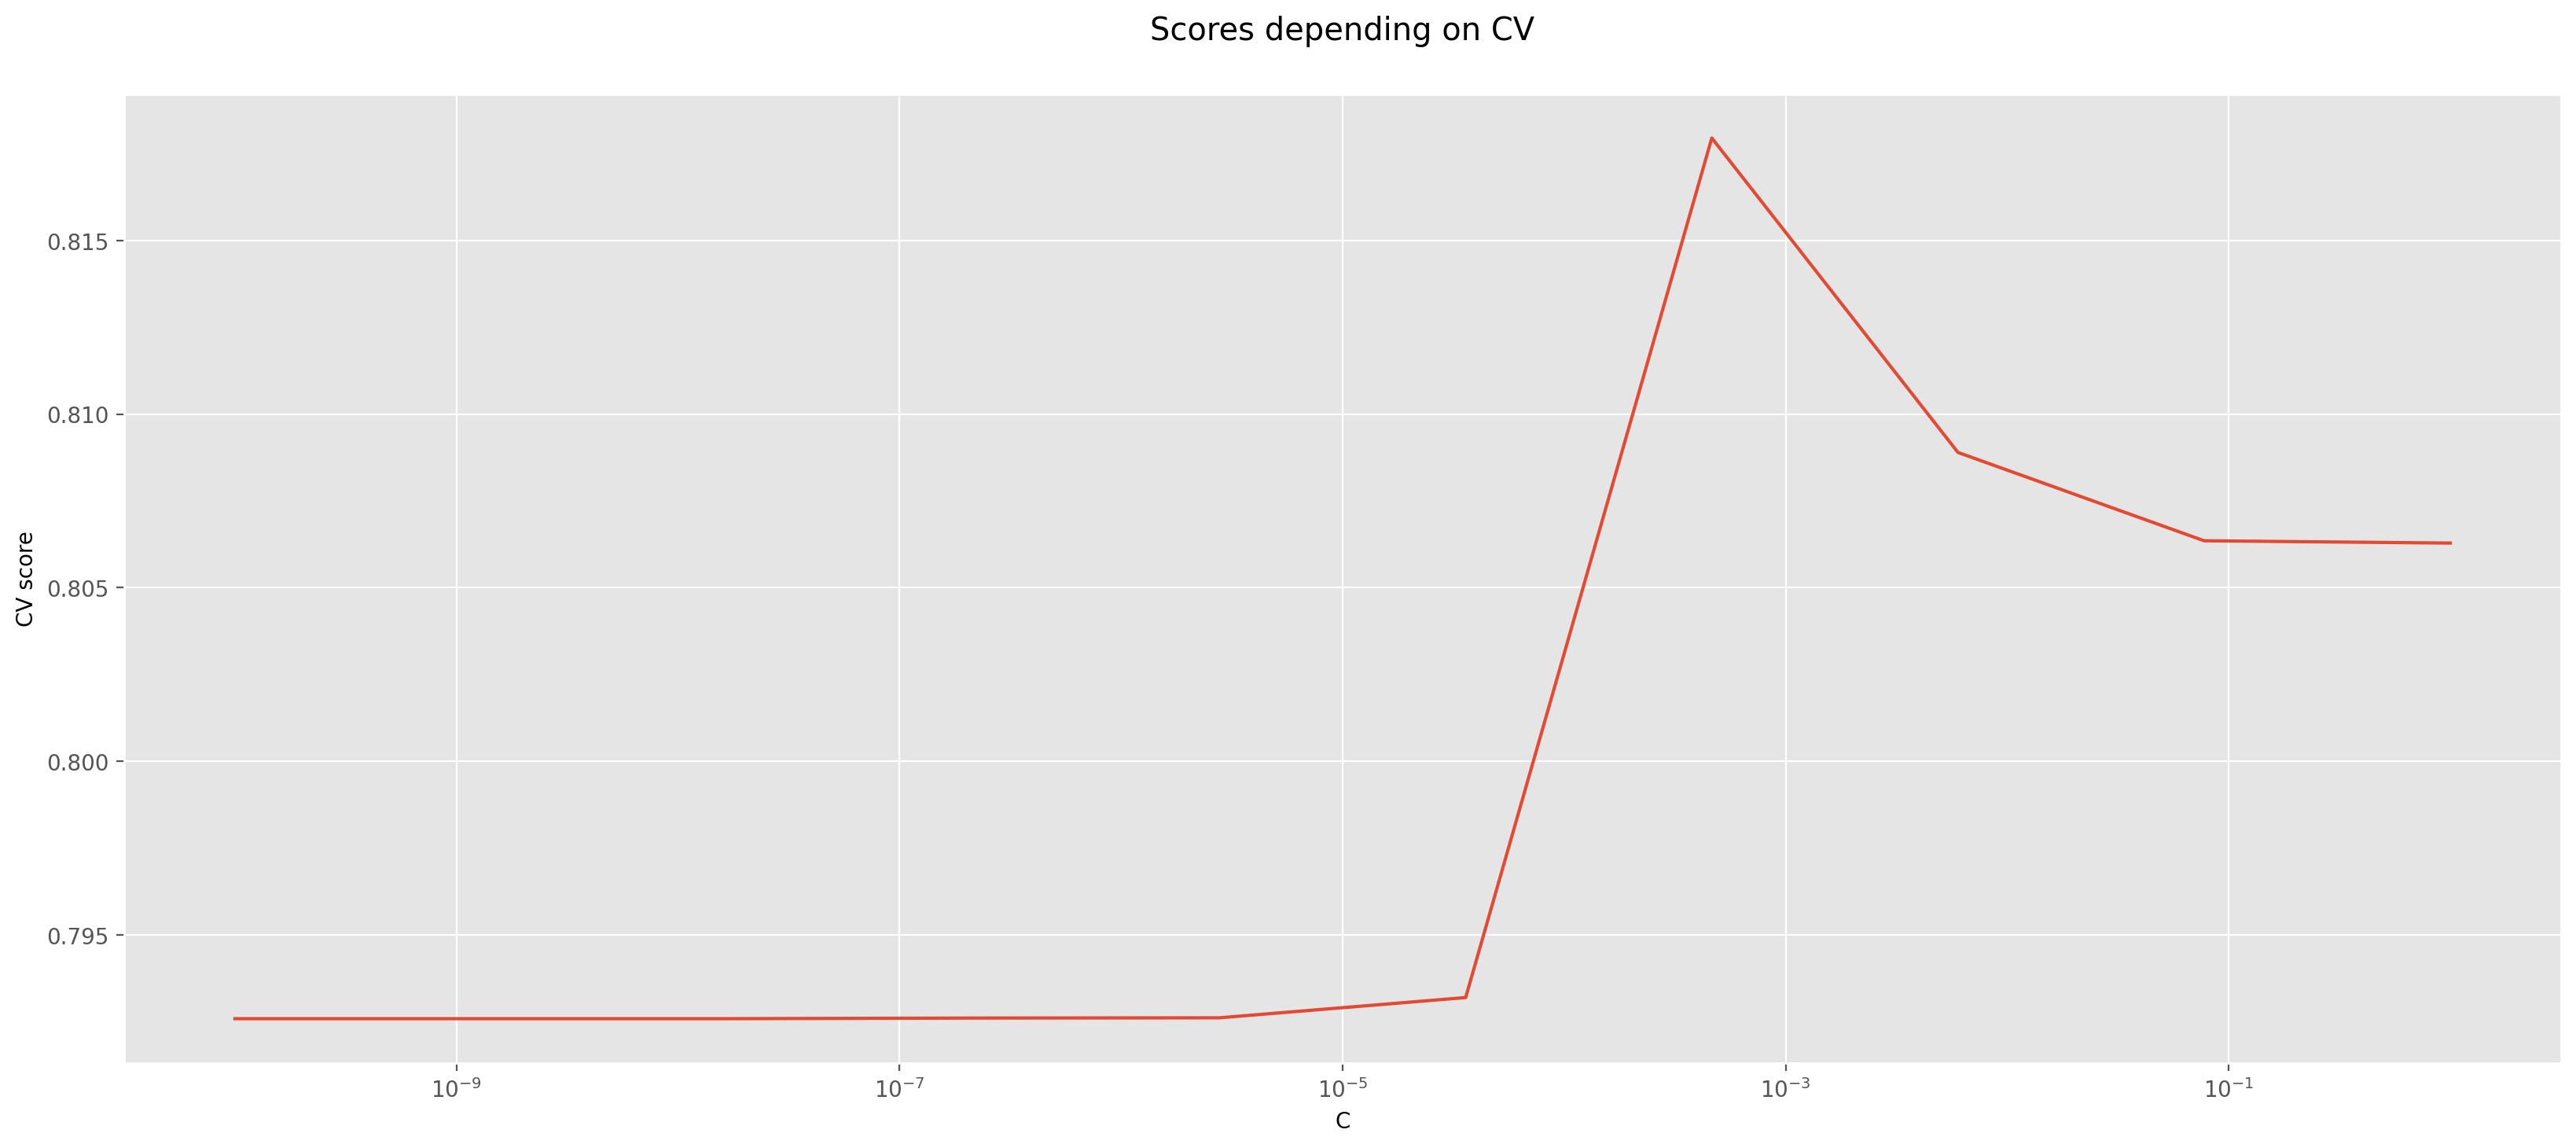

In [12]:
cs = np.logspace(-10, 0, 10)
searcher = GridSearchCV(SVC(kernel="linear"), 
                        [{"C": cs}], 
                        scoring="average_precision", 
                        cv=5
                       )

searcher.fit(X_train_scaled, y_train)

best_c_svc = searcher.best_params_["C"]
print("Best C = %.4f" % best_c_svc)

plt.plot(cs, searcher.cv_results_["mean_test_score"])
plt.title('Scores depending on CV')
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("CV score")
plt.show()

А теперь обучим `LogReg`

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [13]:
clf_svc = SVC(kernel="linear", 
              C=best_c_svc,
              probability=True
)
clf_svc.fit(X_train_scaled, y_train)

y_test_pred_probas_svc = clf_svc.predict_proba(X_test_scaled)[:, 1]
y_test_pred_svc = clf_svc.predict(X_test_scaled)

AUC-PR: 0.82501
AUC-ROC: 0.84436


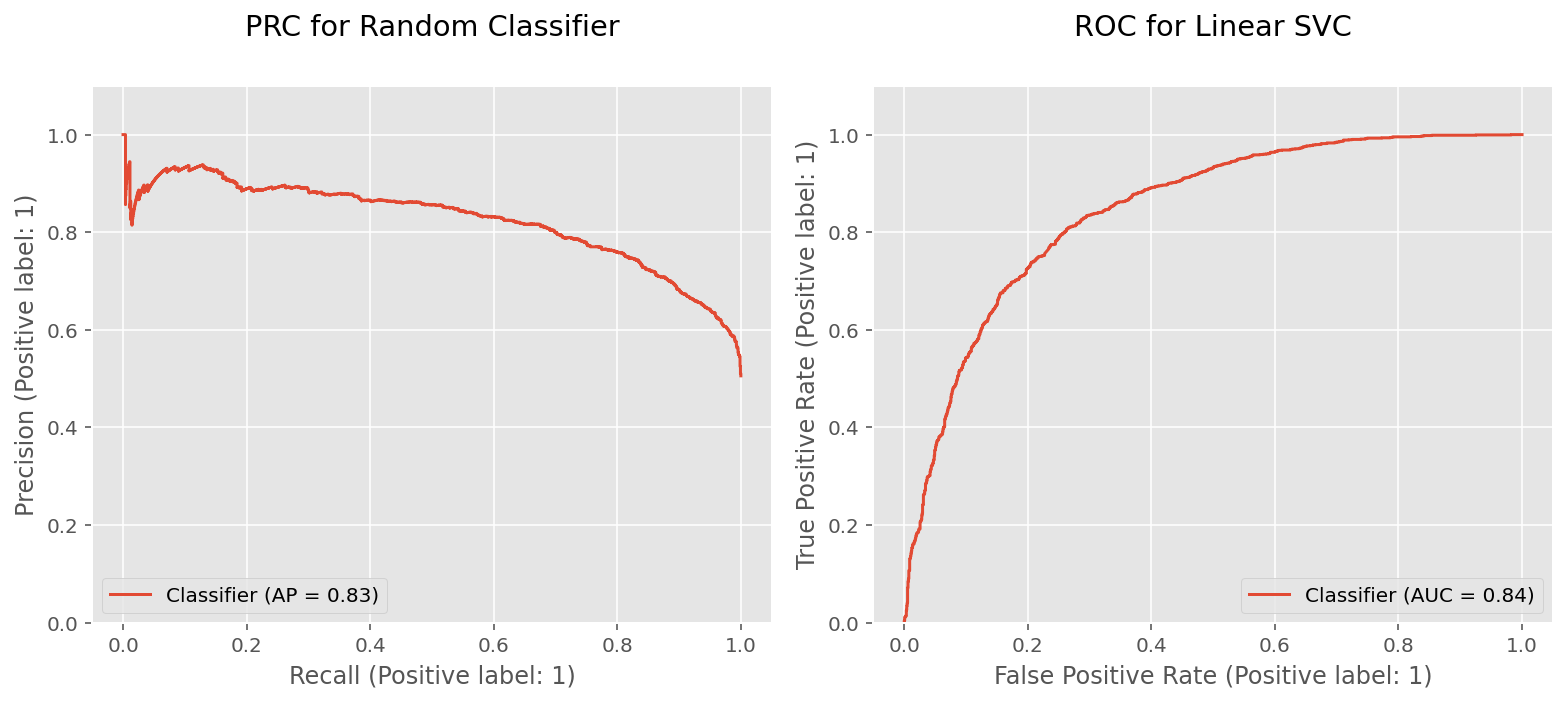

In [14]:
auc_svc, roc_auc_score_svc = plot_prc_roc(y_test_pred_probas_svc, 
                                          y_test,
                                          'Linear SVC'
                                            )

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

__Logistic Regression__

Теперь повторите то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление метрик и построение кривых ROC и PR.

Best C = 0.0060


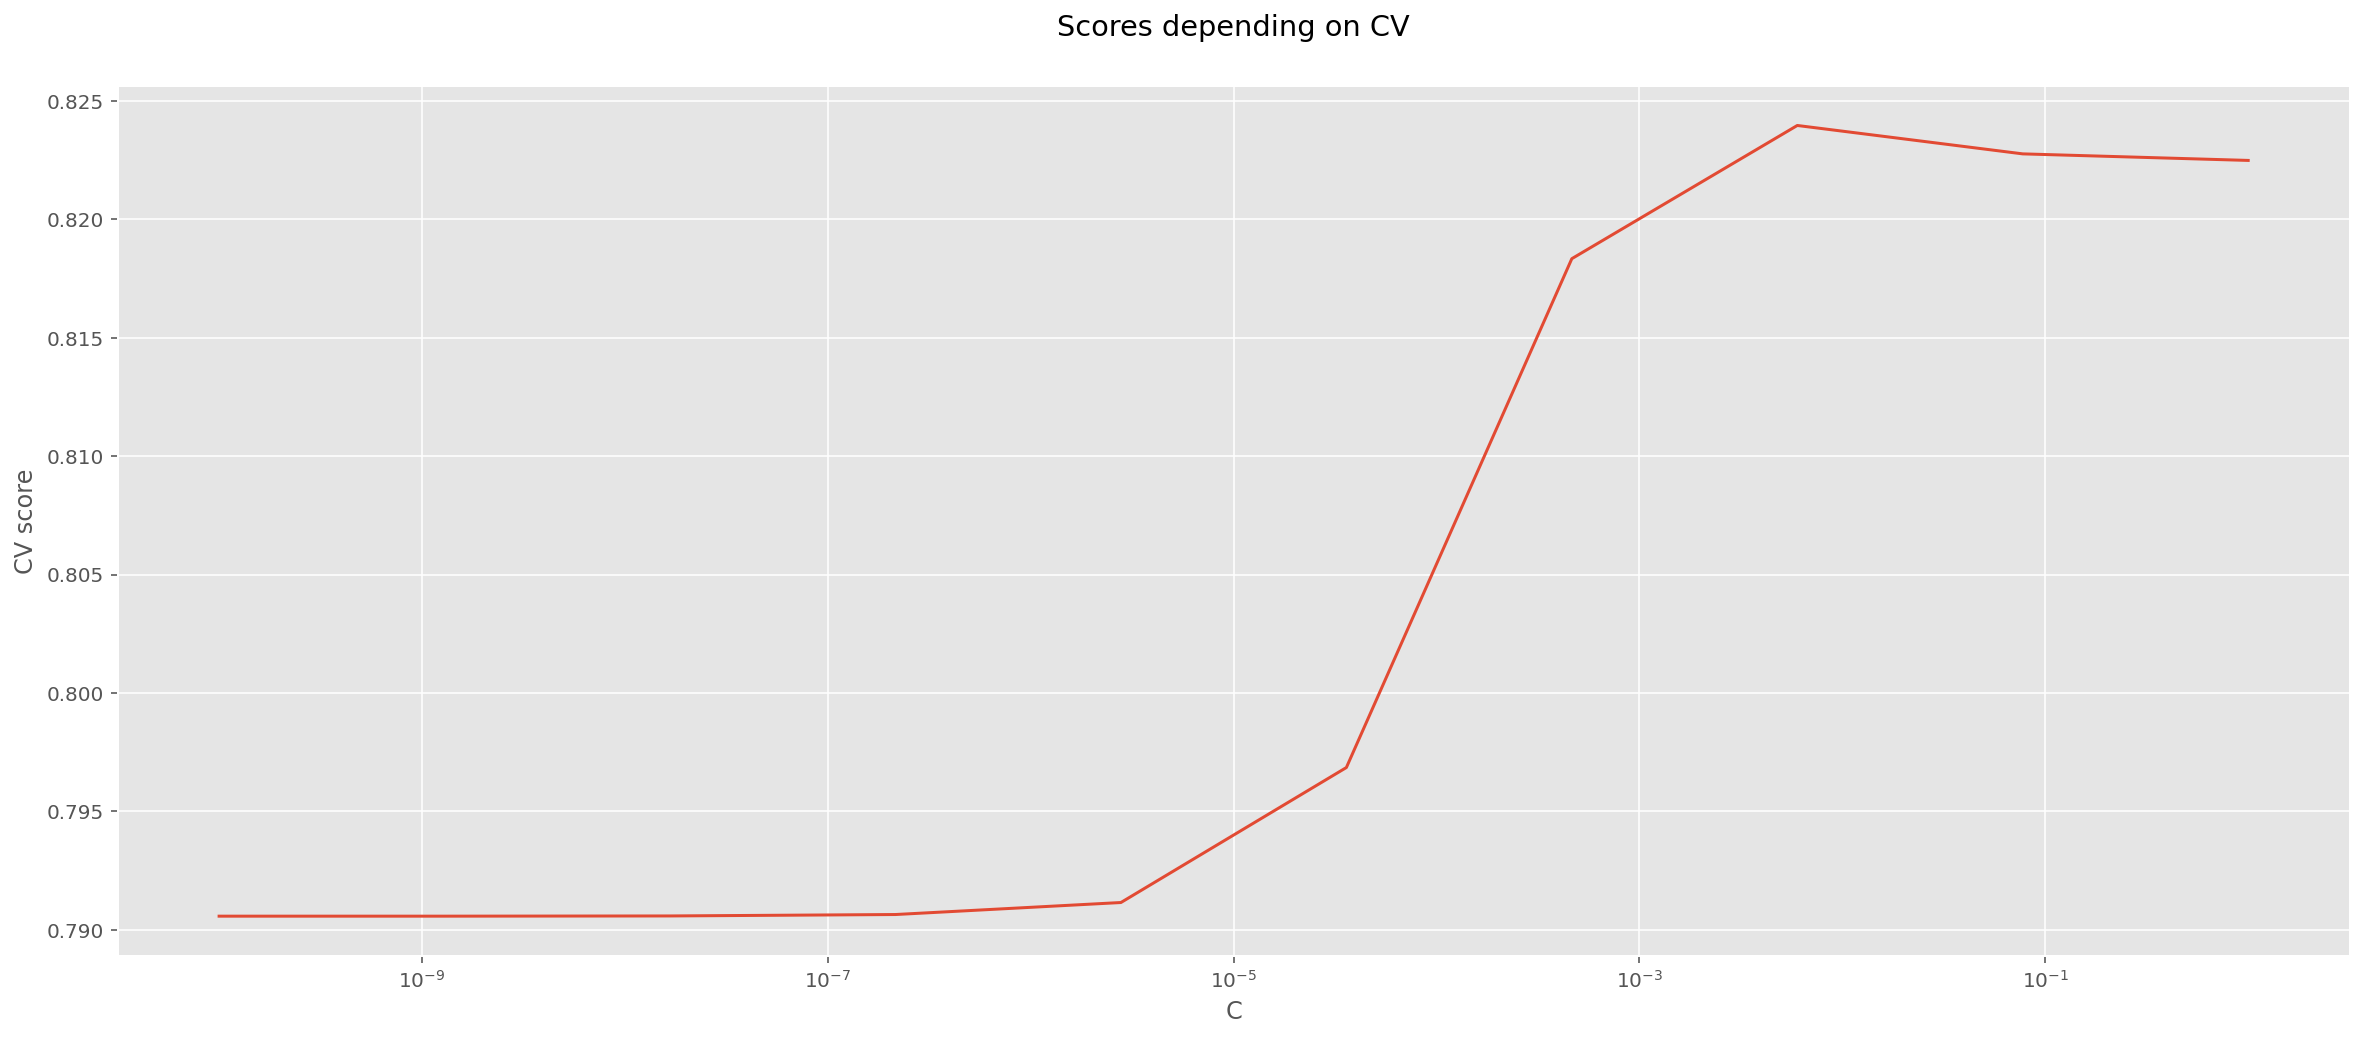

In [15]:
cs = np.logspace(-10, 0, 10)
searcher = GridSearchCV(LogisticRegression(penalty='l2',
                                          ), 
                        [{"C": cs}], 
                        scoring="average_precision", 
                        cv=5
                       )

searcher.fit(X_train_scaled, y_train)

best_c_logreg = searcher.best_params_["C"]
print("Best C = %.4f" % best_c_logreg)

plt.plot(cs, searcher.cv_results_["mean_test_score"])
plt.title('Scores depending on CV')
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("CV score")
plt.show()

In [16]:
clf_logreg = LogisticRegression(penalty='l2',
                             C=best_c_logreg
                            )

clf_logreg.fit(X_train_scaled, y_train)

y_test_pred_probas_logreg = clf_logreg.predict_proba(X_test_scaled)[:, 1]
y_test_pred_logreg = clf_logreg.predict(X_test_scaled)

AUC-PR: 0.83054
AUC-ROC: 0.84697


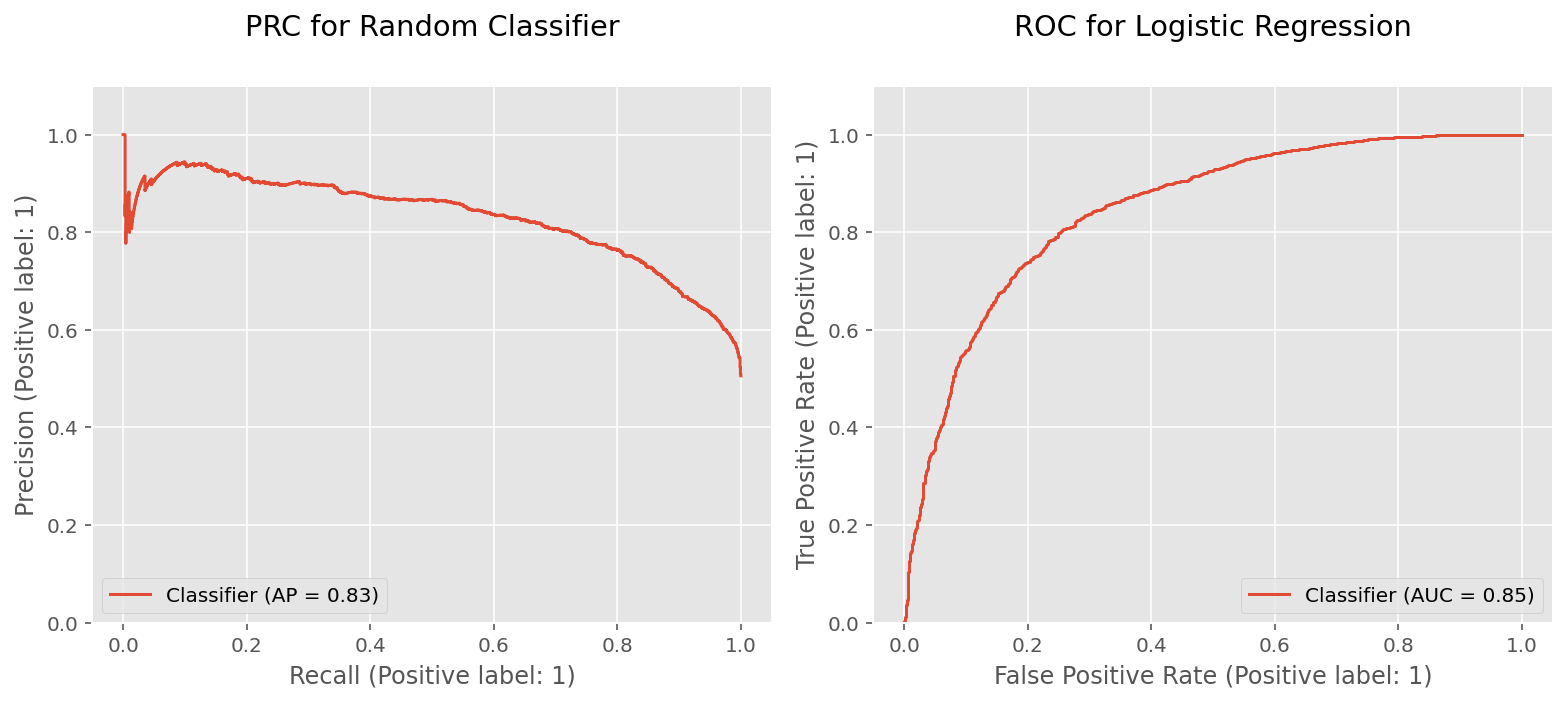

In [17]:
auc_logreg, roc_auc_score_logreg = plot_prc_roc(y_test_pred_probas_logreg, 
                                          y_test,
                                          'Logistic Regression'
                                            )

In [18]:
# добавление очередной строки с характеристиками метода
df_metrics.loc['Linear SVC'] = [
    auc_svc,
    roc_auc_score_svc,
    best_c_svc
]

df_metrics.loc['Logistic Regression'] = [
    auc_logreg,
    roc_auc_score_logreg,
    best_c_logreg
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN
Linear SVC,0.825010,0.844360,0.000464
Logistic Regression,0.830540,0.846970,0.005995


__Микровывод__

  Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

  Ответ:
  
 Особой разницы не наблюдается - значения метрик примерно одинаковым. В целом, для `Logistic Regression` значение обеих метрик чуть лучше

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

1) Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет.

2) Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). 

In [19]:
from sklearn.inspection import DecisionBoundaryDisplay

In [20]:
# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=150, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X = StandardScaler().fit_transform(X)

In [21]:
# clf = SVC(kernel="linear", C=best_c_svc)
# clf.fit(X_train_scaled, y_train)

clf = SVC(kernel="linear")
clf.fit(X, y)

SVC(kernel='linear')

Взято из:
    
https://medium.com/geekculture/svm-classification-with-sklearn-svm-svc-how-to-plot-a-decision-boundary-with-margins-in-2d-space-7232cb3962c0

Тут подробно описано, как отрисовать все компоненты

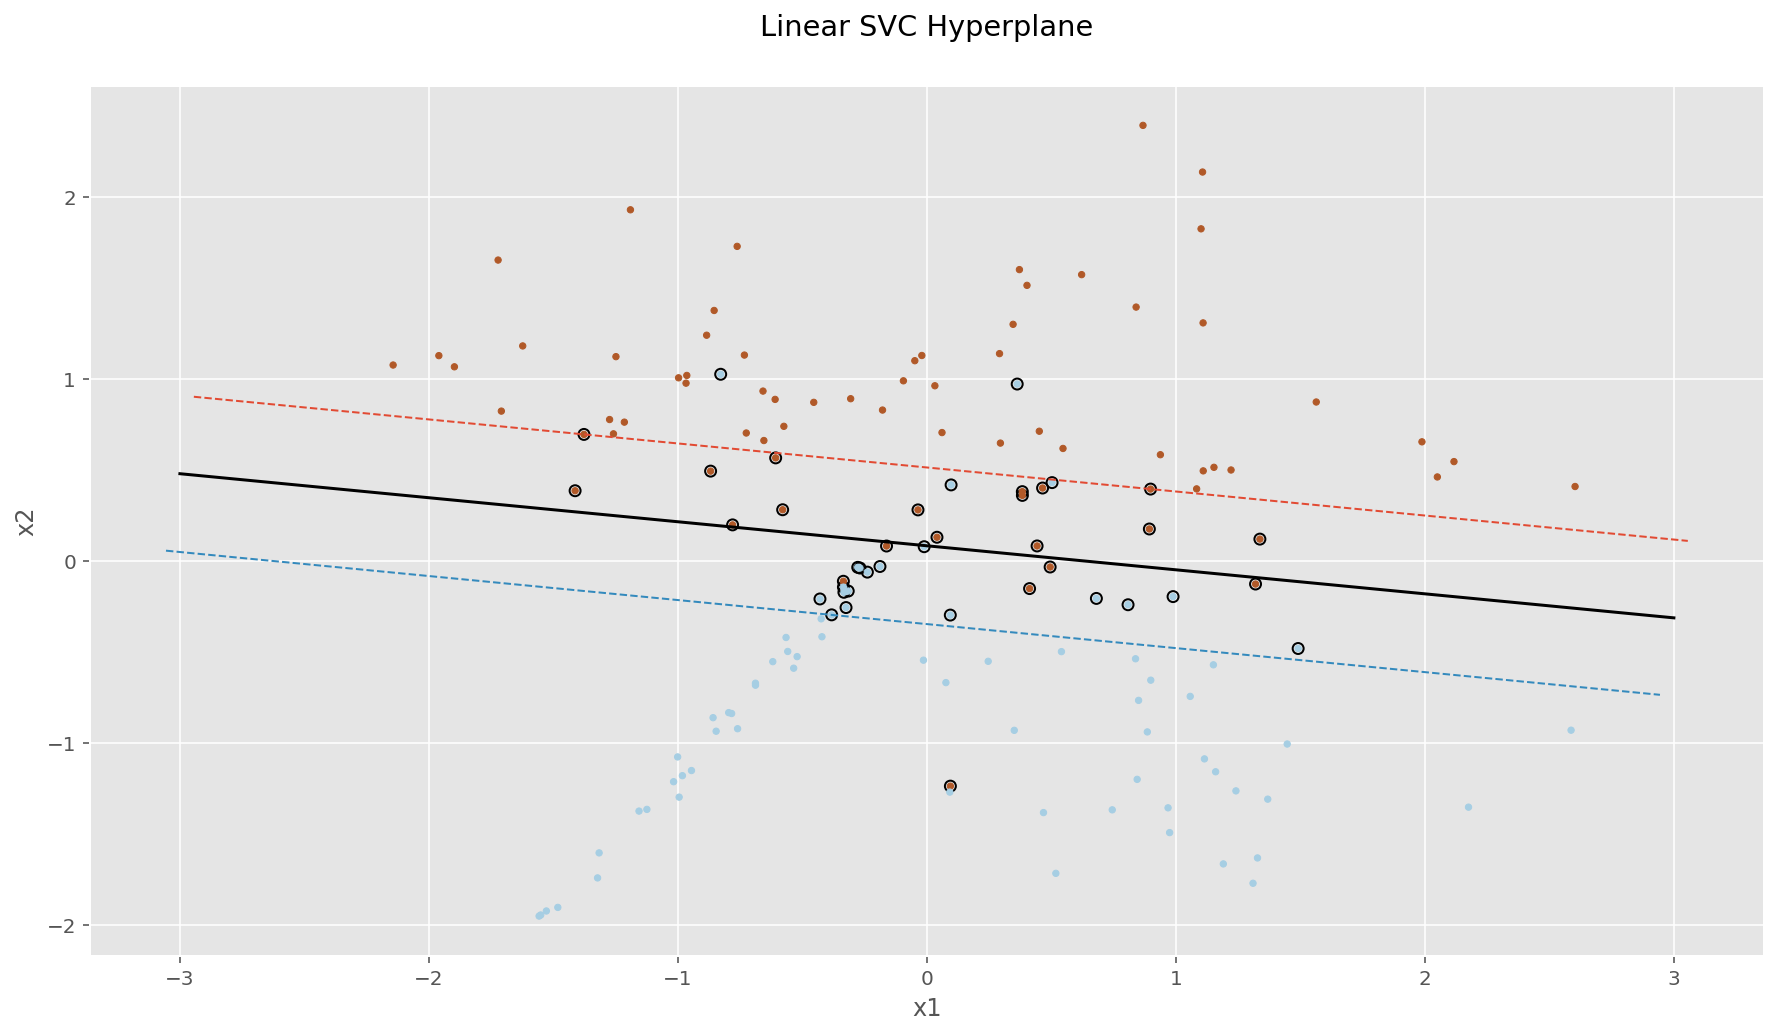

In [23]:
# get the separating hyperplane

plt.figure(figsize=(15, 8))

# --------
# get decision function (simple line function from <w,x> + b = 0)
# w1*x1 + w2*x2 + b -> x2 = - (w1/w2)*x1 - b/w2 
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-3, 3)
yy = a * xx - (clf.intercept_[0]) / w[1]

# scatter support vectors
plt.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=30,
        linewidth=1,
        facecolors="none",
        edgecolors="k"
    )
# scatter all data points
plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=plt.cm.Paired)

#-----------
# compute margins

# orthogonal vector - (weight or coeff). But we need to normalize it w / ||w||
w_hat = clf.coef_[0] / (np.sqrt(np.sum(clf.coef_[0] ** 2)))

# margin 1 / ||w||
margin = 1 / np.sqrt(np.sum(clf.coef_[0] ** 2))

# decision function <w,x> + b = 0)
decision_boundary_points = np.array(list(zip(xx, yy)))

# margin boundaries 
points_of_line_above = decision_boundary_points + w_hat * margin
points_of_line_below = decision_boundary_points - w_hat * margin

# plot margin boundaries
plt.plot(points_of_line_above[:, 0], 
         points_of_line_above[:, 1], 
         '--', 
         linewidth=1)

# plot decision function
plt.plot(xx, yy, "k-")
# Green margin line below
plt.plot(points_of_line_below[:, 0], 
         points_of_line_below[:, 1], 
         '--',
         linewidth=1)

plt.axis("tight")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Linear SVC Hyperplane')
plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor` ([matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py)).

In [24]:
clf = LogisticRegression(penalty='l2',
                            )

clf.fit(X, y)
y_probas = clf.predict_proba(X)

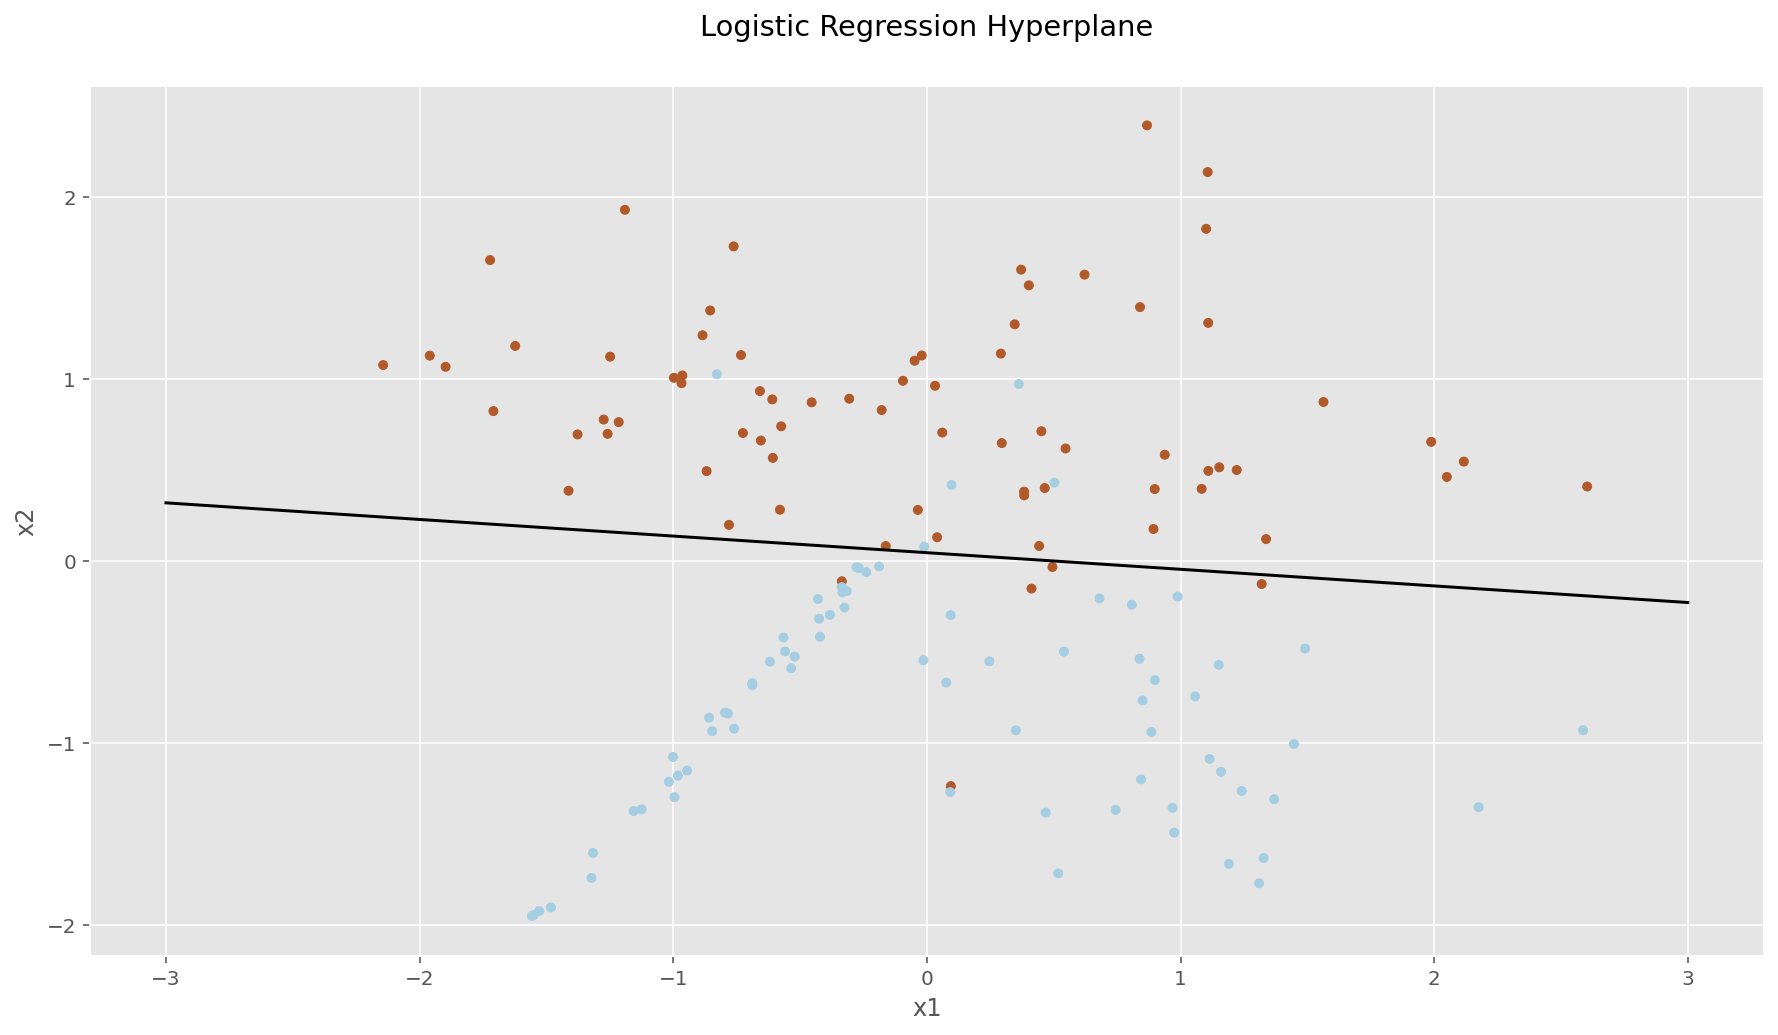

In [25]:
# plot log reg decision function
plt.figure(figsize=(15, 8))

w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-3, 3)
yy = a * xx - (clf.intercept_[0]) / w[1]

# scatter all data points
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Paired)
# plot decision function
plt.plot(xx, yy, "k-")

plt.axis("tight")
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Logistic Regression Hyperplane')
plt.show()

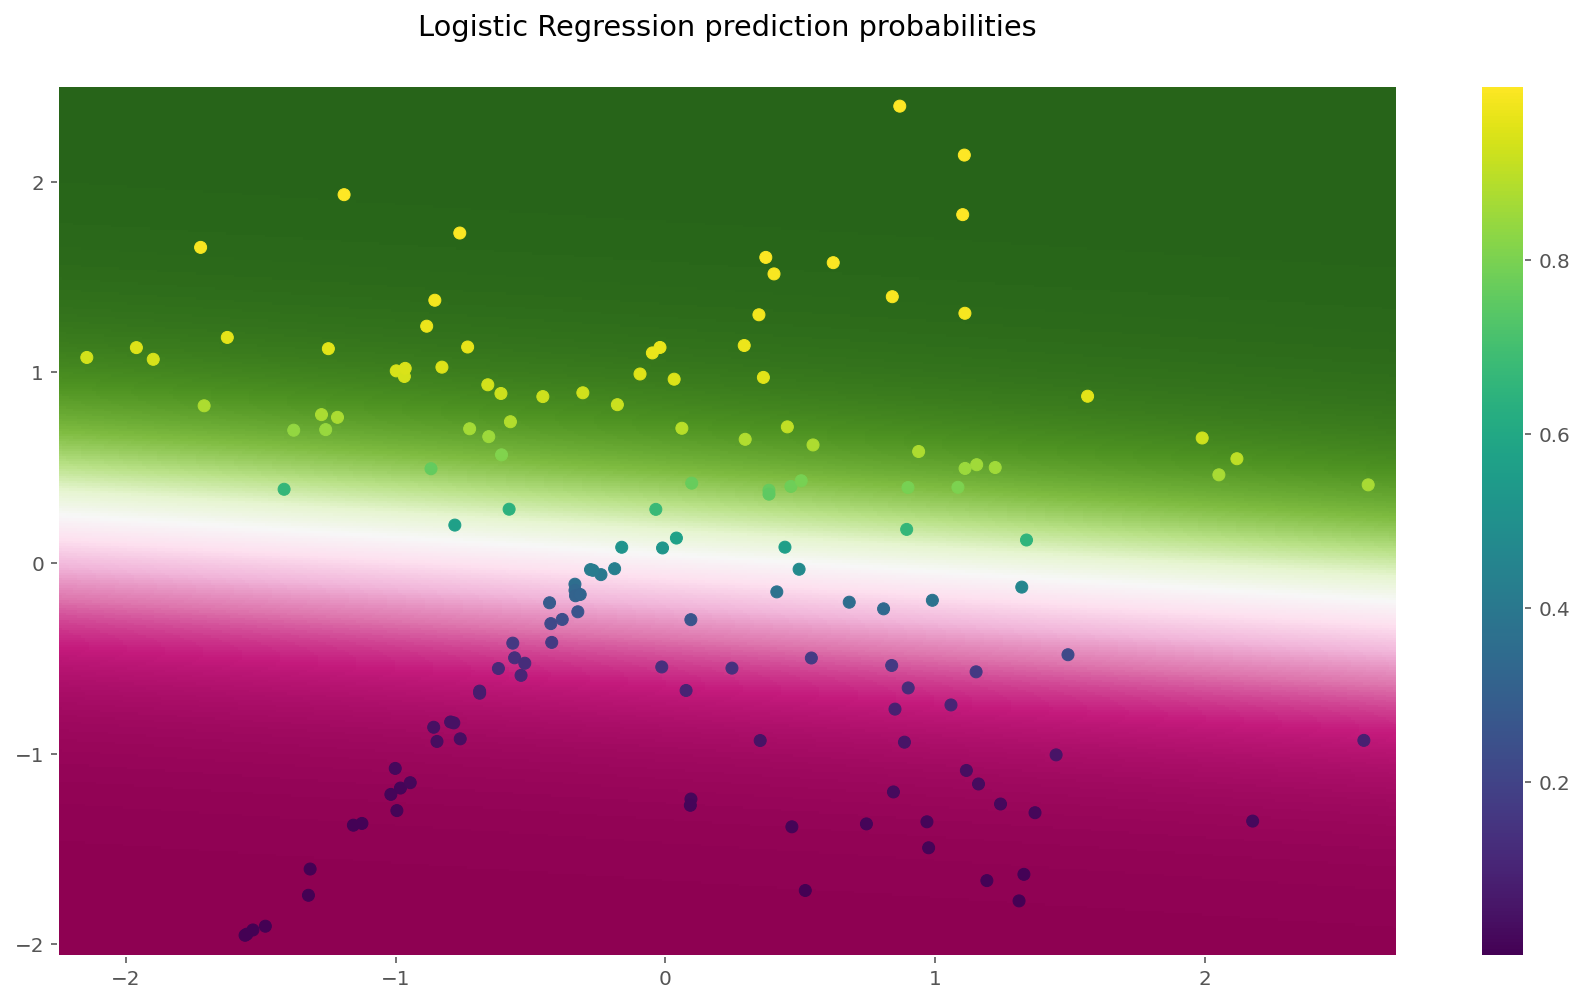

In [26]:
plt.figure(figsize=(15,8))
eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 350),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 350))
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.get_cmap('PiYG'), shading='auto')

plt.scatter(X[:, 0], X[:, 1], c=y_probas[:, 1])
plt.colorbar()
plt.title('Logistic Regression prediction probabilities')
plt.show()

#### __Задание 2. Калибровка вероятностей__ (1 балл)

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [27]:
# я не помню, что конкретно тут поменяла - но сейчас работает
# вроде (l - r)/2 было и ylim([-0.05, 1.05])
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, label='Classifier curve')
    plt.ylim([0, 1])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

In [28]:
# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=rs)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

In [29]:
scaler = StandardScaler().fit(X_train, y_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
cs = np.logspace(-10, 0, 10)
searcher = GridSearchCV(SVC(kernel="linear"), 
                        [{"C": cs}], 
                        scoring="roc_auc", 
                        cv=5
                       )
searcher.fit(X_train_scaled, y_train)
best_c_svc = searcher.best_params_["C"]
clf_svc = SVC(kernel="linear", 
              C=best_c_svc,
              probability=True
)
clf_svc.fit(X_train_scaled, y_train)
svc_pred = clf_svc.decision_function(X_test_scaled)
svc_pred = (svc_pred - svc_pred.min()) / (svc_pred.max() - svc_pred.min()) # -> [0, 1]
y_test_pred_svc = clf_svc.predict(X_test_scaled)

# -----------------------

cs = np.logspace(-10, 0, 10)
searcher = GridSearchCV(LogisticRegression(penalty='l2',
                                          ), 
                        [{"C": cs}], 
                        scoring="roc_auc", 
                        cv=5
                       )
searcher.fit(X_train_scaled, y_train)
best_c_logreg = searcher.best_params_["C"]
clf_logreg = LogisticRegression(penalty='l2',
                             C=best_c_logreg
                            )
clf_logreg.fit(X_train_scaled, y_train)
lr_pred = clf_logreg.predict_proba(X_test_scaled)[:, 1]
y_test_pred_logreg = clf_logreg.predict(X_test_scaled)

Отрисуем калибровочные кривые 

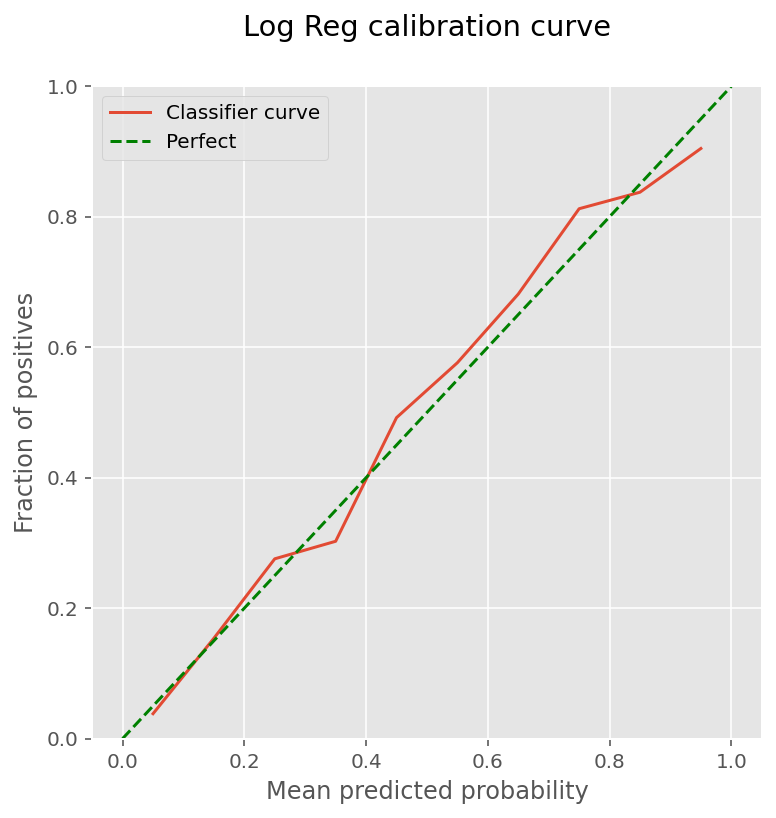

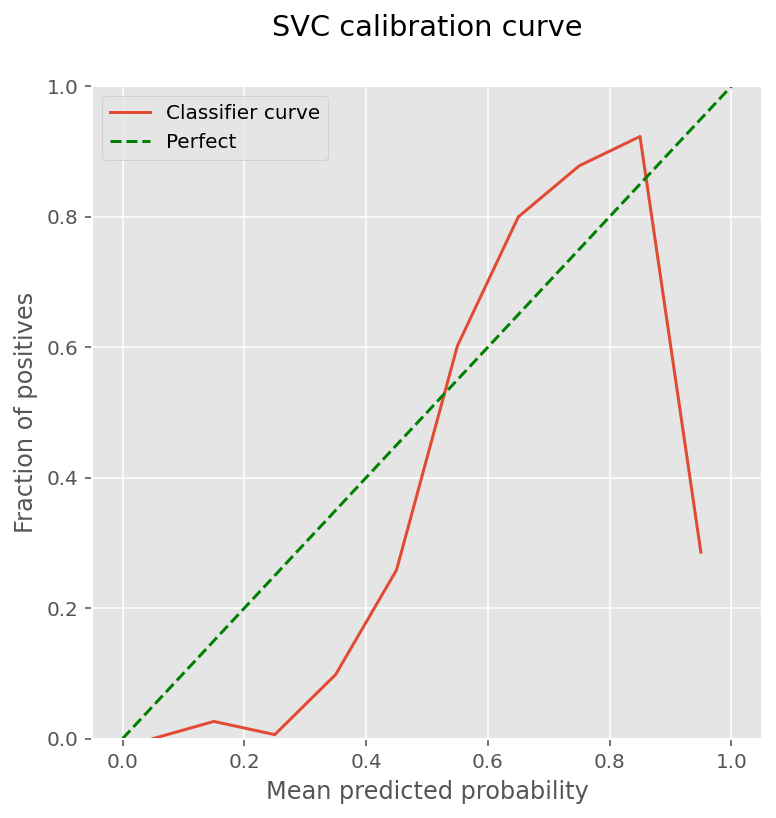

In [31]:
plot_calibration_curve(y_test, lr_pred)
plt.title('Log Reg calibration curve')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.grid()

plot_calibration_curve(y_test, svc_pred)
plt.title('SVC calibration curve')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.grid()

plt.show()

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

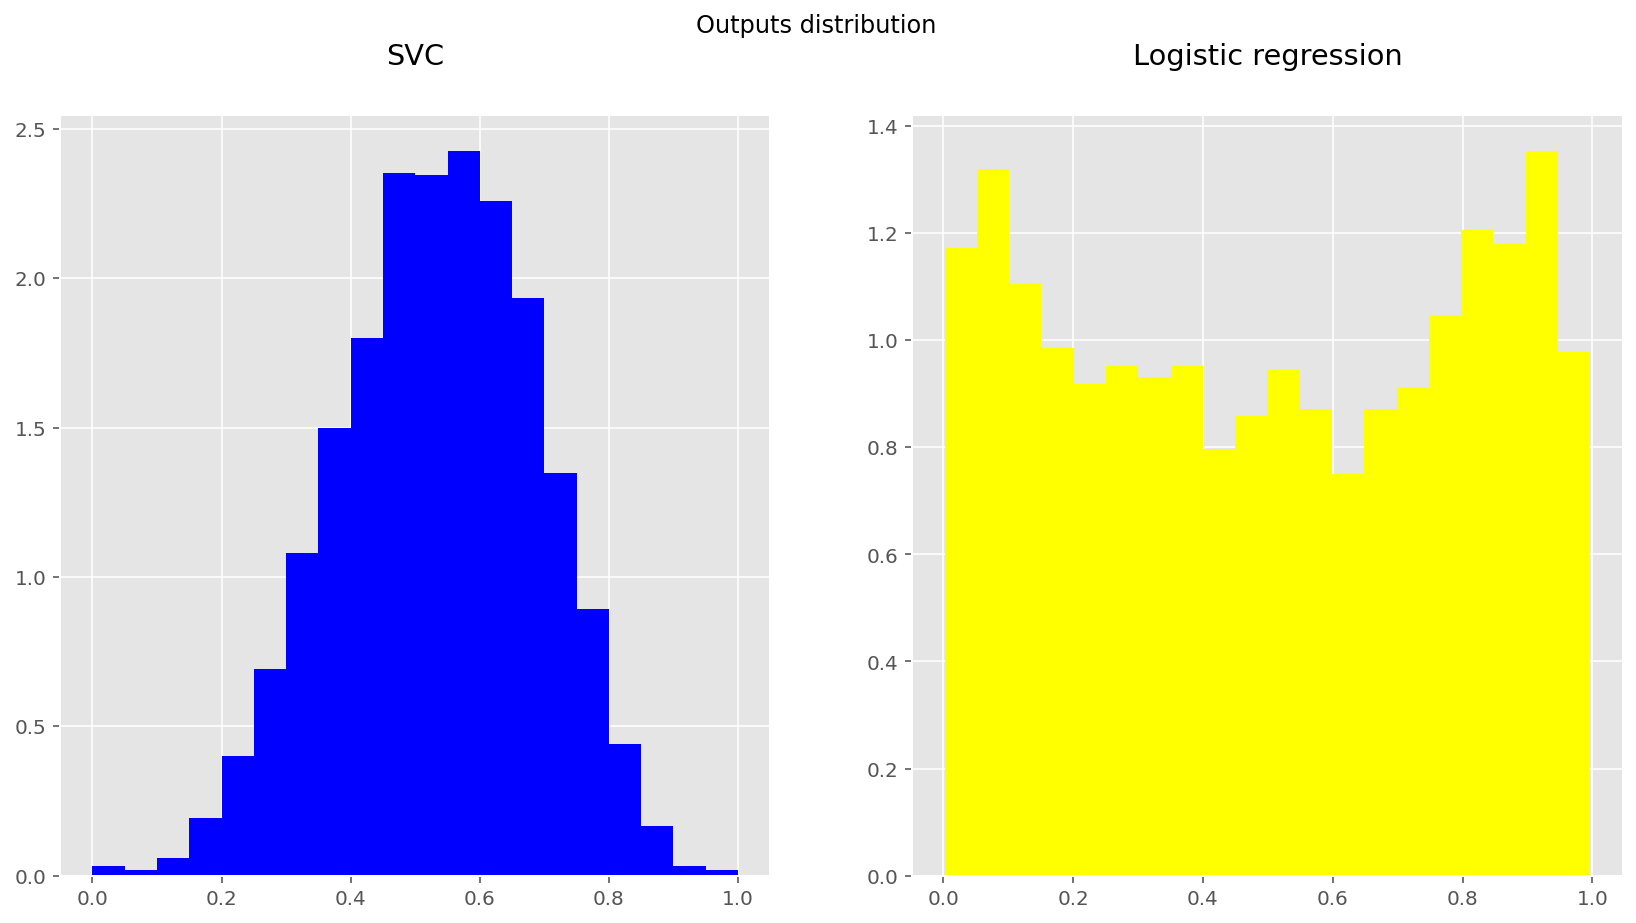

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

axs[0].hist(svc_pred, color='blue',  density='True', bins=20)
axs[1].hist(lr_pred, color='yellow',  density='True', bins=20)

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()


Чем они различаются? Чем вы можете объяснить это?

Ответ: 

В случае с логистической регрессией распределение вероятностей бимодальное: пики находятся около 0 и 1. Это объясняется тем, что `Logistic Regression` выдает вероятности принадлежности к классам. Предсказания `SVC` же просто отображены на отрезок [0, 1]  и имеют нормальное распределение - их нельзя интерпретировать как вероятность принадлежности к классу

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

Используем оба метода калибровки: **Калибровка Платта** и **Изотоническая регрессия**
    

In [33]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [34]:
sigmoid_svc = CalibratedClassifierCV(clf_svc, cv=3, method='sigmoid').fit(X_train_scaled, y_train)
sigmoid_svc_pred = sigmoid_svc.predict_proba(X_test_scaled)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))

SVC ROC-AUC: 0.8478604585211167


In [35]:
isotonic_svc = CalibratedClassifierCV(clf_svc, cv=3, method='isotonic').fit(X_train_scaled, y_train)
isotonic_svc_pred = isotonic_svc.predict_proba(X_test_scaled)[:, 1]
print('SVC ROC-AUC:', roc_auc_score(y_test, isotonic_svc_pred))

SVC ROC-AUC: 0.8479911419733468


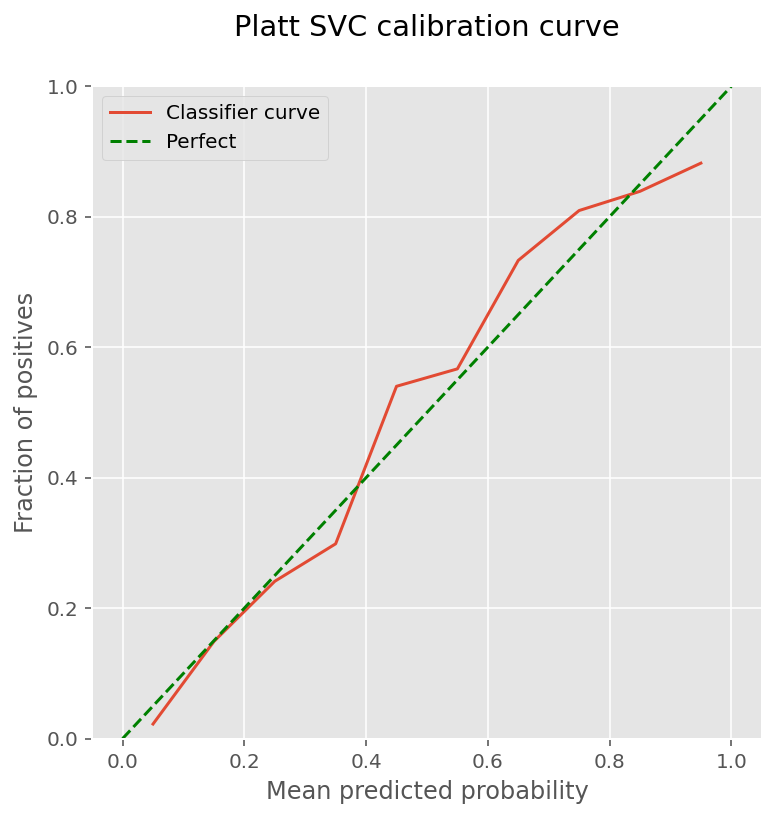

In [36]:
plot_calibration_curve(y_test, sigmoid_svc_pred)
plt.title('Platt SVC calibration curve')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.grid()

plt.show()

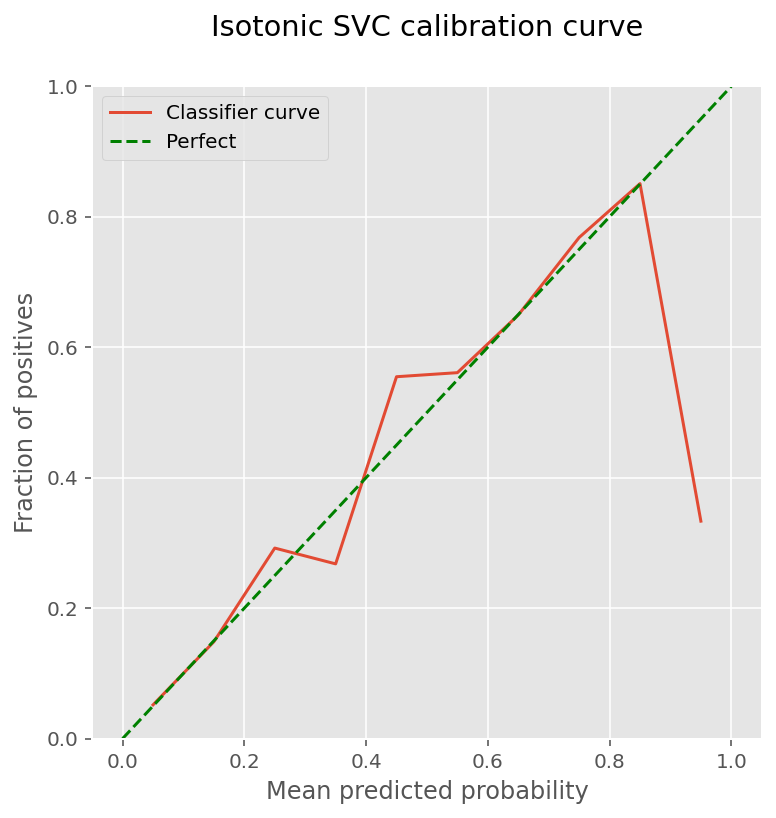

In [37]:
plot_calibration_curve(y_test, isotonic_svc_pred)
plt.title('Isotonic SVC calibration curve')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.grid()

plt.show()

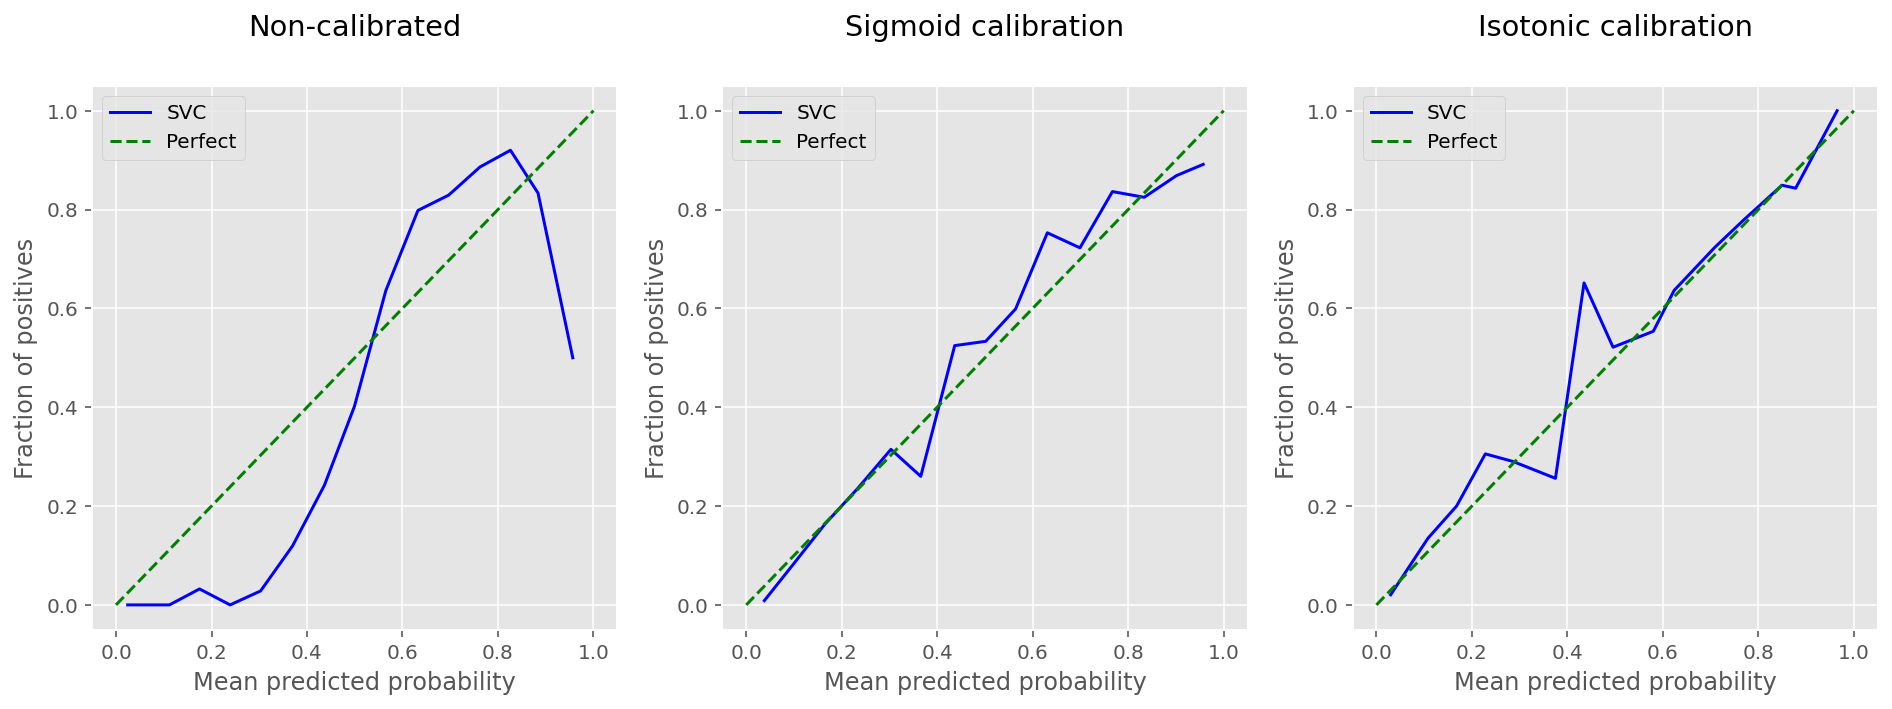

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

svc_true_prob, svc_pred_prob = calibration_curve(y_test, svc_pred, n_bins=15)
axs[0].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[0].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[0].set_title('Non-calibrated')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, sigmoid_svc_pred, n_bins=15)
axs[1].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[1].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[1].set_title('Sigmoid calibration')

svc_true_prob, svc_pred_prob = calibration_curve(y_test, isotonic_svc_pred, n_bins=15)
axs[2].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[2].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[2].set_title('Isotonic calibration')

for ax in axs:
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Fraction of positives')
    ax.legend()

plt.show()

Калибровка помогла - визуально линия теперь совпадает горадо лучше с прямой из (0,0) в (0,1). Кажется, что **Калибровка Платта** несколько лучше, так как второй вариант отклоняется больше

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [39]:
#your code here

# Часть 2. Обработка категориальных переменных

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла. 

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет. 

In [40]:
# ! wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

In [41]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [42]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [43]:
train_idx, test_idx = train_test_split(df.index, 
                                       test_size=0.25, 
                                       random_state=777, 
                                       stratify=df['income']
                                      )

X_train = df.loc[train_idx].drop(['income'], axis=1)
X_test = df.loc[test_idx].drop(['income'], axis=1)

y_train = df.loc[train_idx]['income']
y_test = df.loc[test_idx]['income']

In [44]:
y_train.value_counts(normalize=True)

0    0.759173
1    0.240827
Name: income, dtype: float64

In [45]:
y_test.value_counts(normalize=True)

0    0.759243
1    0.240757
Name: income, dtype: float64

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`, а числовые признаки нормализуйте с помощью `StandardScaler`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [46]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [47]:
target = 'income'

numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
           'capital-loss', 'hours-per-week']
categorical = ['workclass', 'education', 'marital-status', 'occupation',
               'relationship', 'race', 'sex', 'native-country']

# numeric = X_test.select_dtypes(np.number).columns
# categorical = X_train.select_dtypes('object').columns

columns = numeric + categorical

In [48]:
%%time

column_transformer = ColumnTransformer([
    ('ord', OrdinalEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ord_and_scaling', column_transformer),
    ('clf', LogisticRegression(max_iter=1000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.68222
AP: 0.68231
CPU times: user 1.27 s, sys: 386 ms, total: 1.66 s
Wall time: 405 ms


__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ответ__: В выборке значительный дисбаланс классов

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [49]:
%%time

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('clf', LogisticRegression(max_iter=1000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.76715
AP: 0.76722
CPU times: user 611 ms, sys: 6.53 ms, total: 618 ms
Wall time: 617 ms


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [50]:
def apply_counters(X_train: pd.DataFrame, 
                   X_test: pd.DataFrame, 
                   categorical: List, 
                   target: str ='income'):
    
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    for column in categorical:
        X_test_copy[column] = 0
        for category in X_train_copy[column].unique():
            mean = X_train_copy[X_train_copy[column] == category][target].mean()
            X_train_copy.loc[X_train_copy[column] == category, column] = mean
            X_test_copy.loc[X_test_copy[column] == category, column] = mean
    return X_train_copy, X_test_copy

In [51]:
%%time

X_train_c, X_test_c = apply_counters(df.loc[train_idx], 
                                     df.loc[test_idx], 
                                     categorical, 
                                     target='income')

X_train_c.drop(columns=['income'], inplace=True)
X_test_c.drop(columns=['income'], inplace=True)

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('scaling', column_transformer),
    ('clf', LogisticRegression())
])


model = pipeline.fit(X_train_c, y_train)
y_pred = model.predict_proba(X_test_c)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.64889
AP: 0.64900
CPU times: user 451 ms, sys: 34.6 ms, total: 485 ms
Wall time: 379 ms


Обучается побыстрее, чем `ohe`

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin

In [54]:
class CountEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 columns):
        self.columns = columns
        self.statistics = {}
    
    def init(self):
        super().__init__()
        
    def fit(self, 
            X_train,  
            y_train):
        
        # copy df
        X_train_copy = X_train.copy()
        # add column with y
        X_train_copy['y'] = y_train
        
        # save statistics - mean for each category
        for feat in self.columns:
            self.statistics[feat] = X_train_copy.groupby(feat).mean()[['y']]
        return self
        
    def transform(self, 
                  X_test): 
        
        # copy df
        X_test_copy = X_test.copy()
        
        # iterate through columns
        for feat in self.columns:
            
            # make a join -> add y column with y mean statistics for the given category
            X_test_copy = X_test_copy.join(
                    self.statistics[feat], 
                    on=feat, 
                )
            # put that mean statistics to feature column
            X_test_copy[feat] = X_test_copy['y']
            # drop the y column
            X_test_copy.drop('y', 
                          axis=1, 
                          inplace=True
                         )           
        return X_test_copy
    
    def fit_transform(self, 
                      X_train, 
                      y_train):
        self.fit(X_train, y_train)
        return self.transform(X_train)
        

In [55]:
%%time

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric),
    ('other',  'passthrough', categorical)
])

pipeline = Pipeline(steps=[
    ('cnt', CountEncoder(columns=categorical)),
    ('scaling', column_transformer),
    ('clf', LogisticRegression(max_iter=1000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.75579
AP: 0.75586
CPU times: user 595 ms, sys: 174 ms, total: 769 ms
Wall time: 247 ms


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

In [56]:
class NoiseCountEncoder(CountEncoder):
    def init(self):
        super().__init__()
             
        
    def transform(self, 
                  X_test, 
                  eps=10):  
        # copy df
        X_test_copy = X_test.copy()
        
        # iterate throgh features
        for feat in self.columns:
            
            # add y column with mean category statistics
            X_test_copy = X_test_copy.join(
                self.statistics[feat], 
                on=feat
            )
            
            # count std of feature on train data
            std = X_test_copy['y'].std()
            
            # add noise from random uniform [-std, std] and scale by param eps
            X_test_copy[feat] = X_test_copy['y'] + np.random.uniform(
                -std, std, 
                size=X_test_copy.shape[0]) / eps
            
            # drop y column
            X_test_copy.drop('y', axis=1, inplace=True)
            
        return X_test_copy

In [57]:
%%time

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric),
    ('other',  'passthrough', categorical)
])

pipeline = Pipeline(steps=[
    ('cnt', NoiseCountEncoder(columns=categorical)),
    ('scaling', column_transformer),
    ('clf', LogisticRegression(max_iter=1000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.75569
AP: 0.75577
CPU times: user 524 ms, sys: 146 ms, total: 669 ms
Wall time: 221 ms


##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты.


In [58]:
class SmoothCountEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 columns, 
                 C=10):
        self.columns = columns
        self.statistics = {}
        self.C = C
    
    def init(self):
        super().__init__()
        
    def fit(self, 
            X_train, 
            y_train):
        
        # copy df
        X_train_copy = X_train.copy()
        
        # add y column
        X_train_copy['y'] = y_train
        
        # iterate through columns
        for feat in self.columns:
            
            # count statistics according to the formula: 
            # (sum(y for this category) + C*y_mean) / ((num of objects in this category) + C)
            self.statistics[feat] = X_train_copy.groupby(
                feat).sum()[['y']] \
            + self.C * X_train_copy['y'].mean() \
            / X_train_copy.groupby(feat).count()[['y']] \
            + self.C
            
        return self
        
    def transform(self, X_test):   
        
        # copy df
        X_test_copy = X_test.copy()
        
        # iterate through features
        for feat in self.columns:
            
            # add y column with statistics
            X_test_copy = X_test_copy.join(
                self.statistics[feat], 
                on=feat
            )
            
            # add feature column
            X_test_copy[feat] = X_test_copy['y']
            
            # drop y column
            X_test_copy.drop('y', axis=1, inplace=True)
        return X_test_copy
            
    def fit_transform(self, X_train, y_train):
        self.fit(X_train, y_train)
        return self.transform(X_train)

In [59]:
%%time

column_transformer = ColumnTransformer([
    ('scaling', StandardScaler(), numeric),
    ('other',  'passthrough', categorical)
])

pipeline = Pipeline(steps=[
    ('cnt', SmoothCountEncoder(columns=categorical)),
    ('scaling', column_transformer),
    ('clf', LogisticRegression(max_iter=1000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.74350
AP: 0.74358
CPU times: user 1.84 s, sys: 524 ms, total: 2.36 s
Wall time: 675 ms


#### __Задание 8. И все-таки числовой?__  (0.5 балла)

В данных имеются признаки "возраст" и "число рабочих часов в неделю". Сейчас мы интерпретируем их как числовые, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?



In [60]:
print(f"Количество уникальных значений признака `age`: {df['age'].nunique()}")
print(f"Количество уникальных значений признакаn`hours-per-week`: {df['hours-per-week'].nunique()}")

Количество уникальных значений признака `age`: 73
Количество уникальных значений признакаn`hours-per-week`: 94


In [61]:
# возраст -> категория
numeric = ['fnlwgt', 'education-num', 'capital-gain', 
           'capital-loss', 'hours-per-week']
categorical_cnt = ['age']
categorical = ['workclass', 'education', 'marital-status', 'occupation',
               'relationship', 'race', 'sex', 'native-country']

columns = numeric + categorical + categorical_cnt

In [62]:
%%time

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
])

pipeline = Pipeline(steps=[
    ('cnt', CountEncoder(columns=categorical_cnt)),
    ('scaling', column_transformer),
    ('clf', LogisticRegression(max_iter=1000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.76228
AP: 0.76235
CPU times: user 610 ms, sys: 5.54 ms, total: 616 ms
Wall time: 613 ms


--------------

In [63]:
# число рабочих дней -> категория
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
           'capital-loss']
categorical_cnt = ['hours-per-week']
categorical = ['workclass', 'education', 'marital-status', 'occupation',
               'relationship', 'race', 'sex', 'native-country']

columns = numeric + categorical + categorical_cnt

In [64]:
%%time

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
])

pipeline = Pipeline(steps=[
    ('cnt', CountEncoder(columns=categorical_cnt)),
    ('scaling', column_transformer),
    ('clf', LogisticRegression(max_iter=1000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.75966
AP: 0.75973
CPU times: user 604 ms, sys: 5.93 ms, total: 610 ms
Wall time: 607 ms


--------------

In [65]:
# возраст, число рабочих дней -> категория
numeric = ['fnlwgt', 'education-num', 'capital-gain', 
           'capital-loss']
categorical_cnt = ['age', 'hours-per-week']
categorical = ['workclass', 'education', 'marital-status', 'occupation',
               'relationship', 'race', 'sex', 'native-country']

columns = numeric + categorical + categorical_cnt

In [66]:
%%time

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
])

pipeline = Pipeline(steps=[
    ('cnt', CountEncoder(columns=categorical_cnt)),
    ('scaling', column_transformer),
    ('clf', LogisticRegression(max_iter=1000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.75650
AP: 0.75658
CPU times: user 600 ms, sys: 5.35 ms, total: 605 ms
Wall time: 604 ms


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 

Плюсы:
* Кодирование с помощью счетчиков не увеличивает размерность признакового пространства (сохраняем n>k, нарушение этого условия ведет к плохой обусловленности)
* Учет информации о таргете

Минусы:
* Учет информации о таргете может приводить к переобучению и утечке таргета, поэтому нужно быть супер аккуратным и подумОть

# Часть 3. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про предсказание дохода.

In [374]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [375]:
X = df[columns].drop('income', axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=777, 
                                                    stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding, считая возраст и число часов числовыми. Сколько новых признаков мы получим?

In [376]:
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
           'capital-loss', 'hours-per-week']
categorical = ['workclass', 'education', 'marital-status', 'occupation',
               'relationship', 'race', 'sex', 'native-country']

In [377]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

shape_orig = X_train.shape[1]
print(f"Исходный размер выборки: {shape_orig}")
X_trans = column_transformer.fit_transform(X_train)
shape_trans = X_trans.shape[1]
print(f"Размер после кодирования ohe: {shape_trans}")
diff = shape_trans - shape_orig
print(f"Количество признаков увеличилось на {diff}")

Исходный размер выборки: 14
Размер после кодирования ohe: 108
Количество признаков увеличилось на 94


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [378]:
%%time

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('clf', LogisticRegression(max_iter=10000))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.76715
AP: 0.76722
CPU times: user 589 ms, sys: 3.44 ms, total: 592 ms
Wall time: 591 ms


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



Здесь будем использовать pd.get_dummies, чтобы выкидывать признаки, просто взяв срез по колонкам датафрейма.

Так как мы уже поделили все на трейн / тест и волшебного параметра `handle_unknown='ignore'` тут нет, делаем следующий костыль:
    
* Получаем даммиз трейна и теста в отдельности
* Колонки, оказавшиеся только в одной из частей, заполняем нулями
* Реиндексируем колонки теста как в трейне (если этого не сделать - будет ошибка)

In [379]:
X_train_enc = pd.get_dummies(X_train, columns=categorical)
X_test_enc = pd.get_dummies(X_test, columns=categorical)
for col in set(X_train_enc.columns) - set(X_test_enc.columns):
    X_test_enc[col] = 0
for col in set(X_test_enc.columns) - set(X_train_enc.columns):
    X_train_enc[col] = 0
    
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns)

s = StandardScaler().fit(X_train_enc[numeric])
X_train_enc[numeric] = s.transform(X_train_enc[numeric])
X_test_enc[numeric] = s.transform(X_test_enc[numeric])

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_enc, y_train)
y_pred = logreg.predict_proba(X_test_enc)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.76714
AP: 0.76721


Теперь нарисуем топ-40 фичей и обучимся только на них

In [220]:
%%time
feature_imp = pd.DataFrame({'feature': X_train_enc.columns, 
                            'importance': abs(logreg.coef_[0]),
                            'w': logreg.coef_[0]})
top_40 = feature_imp.sort_values('importance', ascending=False).head(40)
top_40.set_index('feature', inplace=True)#['feature']

CPU times: user 3.08 ms, sys: 1.43 ms, total: 4.5 ms
Wall time: 991 µs


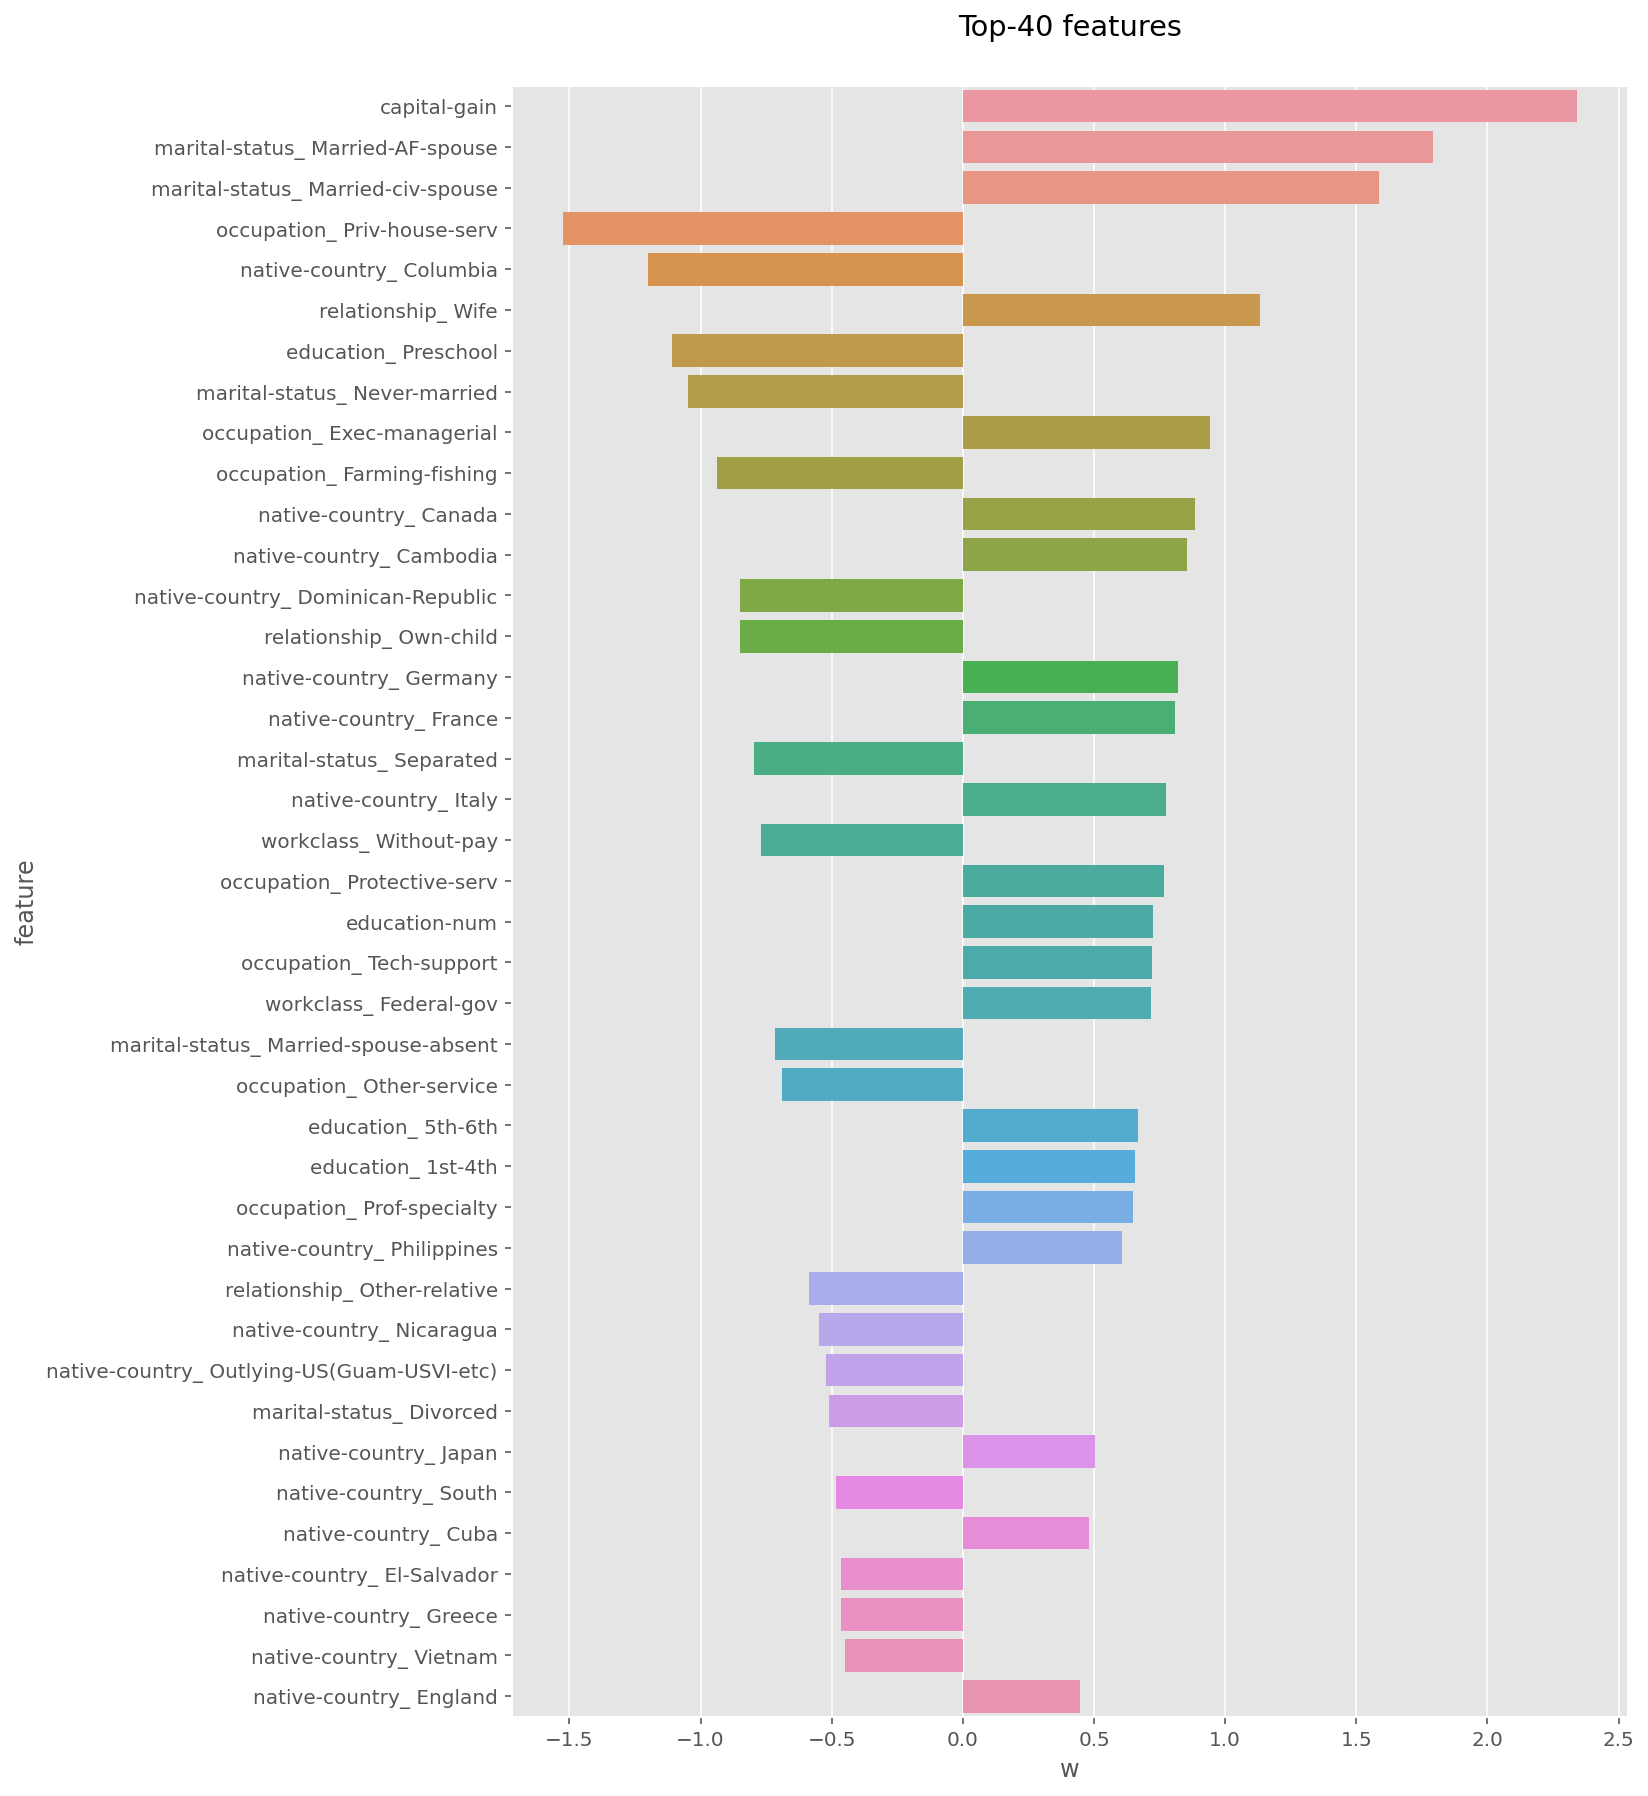

In [221]:
plt.figure(figsize=(10, 15))
sns.barplot(y=top_40.index, x=top_40.w)
plt.title('Top-40 features')
plt.show()

In [222]:
numeric_temp = list(set(top_40.index) & set(numeric))
if len(numeric_temp) != 0:
    s = StandardScaler().fit(X_train_enc[numeric_temp])
    X_train_enc[numeric_temp] = s.transform(X_train_enc[numeric_temp])
    X_test_enc[numeric_temp] = s.transform(X_test_enc[numeric_temp])

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_enc[top_40.index], y_train)
y_pred = logreg.predict_proba(X_test_enc[top_40.index])[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.73774
AP: 0.73156


Качество упало, но все же осталось на приемлемом уровне

Изменилось ли качество? Как?

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

Ну мы уже масштабировали признаки, поэтому теперь, наоборот, уберем `StandardScaler`

In [223]:
X_train_enc = pd.get_dummies(X_train, columns=categorical)
X_test_enc = pd.get_dummies(X_test, columns=categorical)
for col in set(X_train_enc.columns) - set(X_test_enc.columns):
    X_test_enc[col] = 0
for col in set(X_test_enc.columns) - set(X_train_enc.columns):
    X_train_enc[col] = 0
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns)

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_enc, y_train)
y_pred = logreg.predict_proba(X_test_enc)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.45033
AP: 0.45042


Без масштабирования вышло как-то грустно. Отберем признаки теперь

In [224]:
%%time
feature_imp = pd.DataFrame({'feature': X_train_enc.columns, 
                            'importance': abs(logreg.coef_[0]),
                            'w': logreg.coef_[0]})
top_40 = feature_imp.sort_values('importance', ascending=False).head(40)
top_40.set_index('feature', inplace=True)#['feature']

CPU times: user 2.87 ms, sys: 792 µs, total: 3.67 ms
Wall time: 3.03 ms


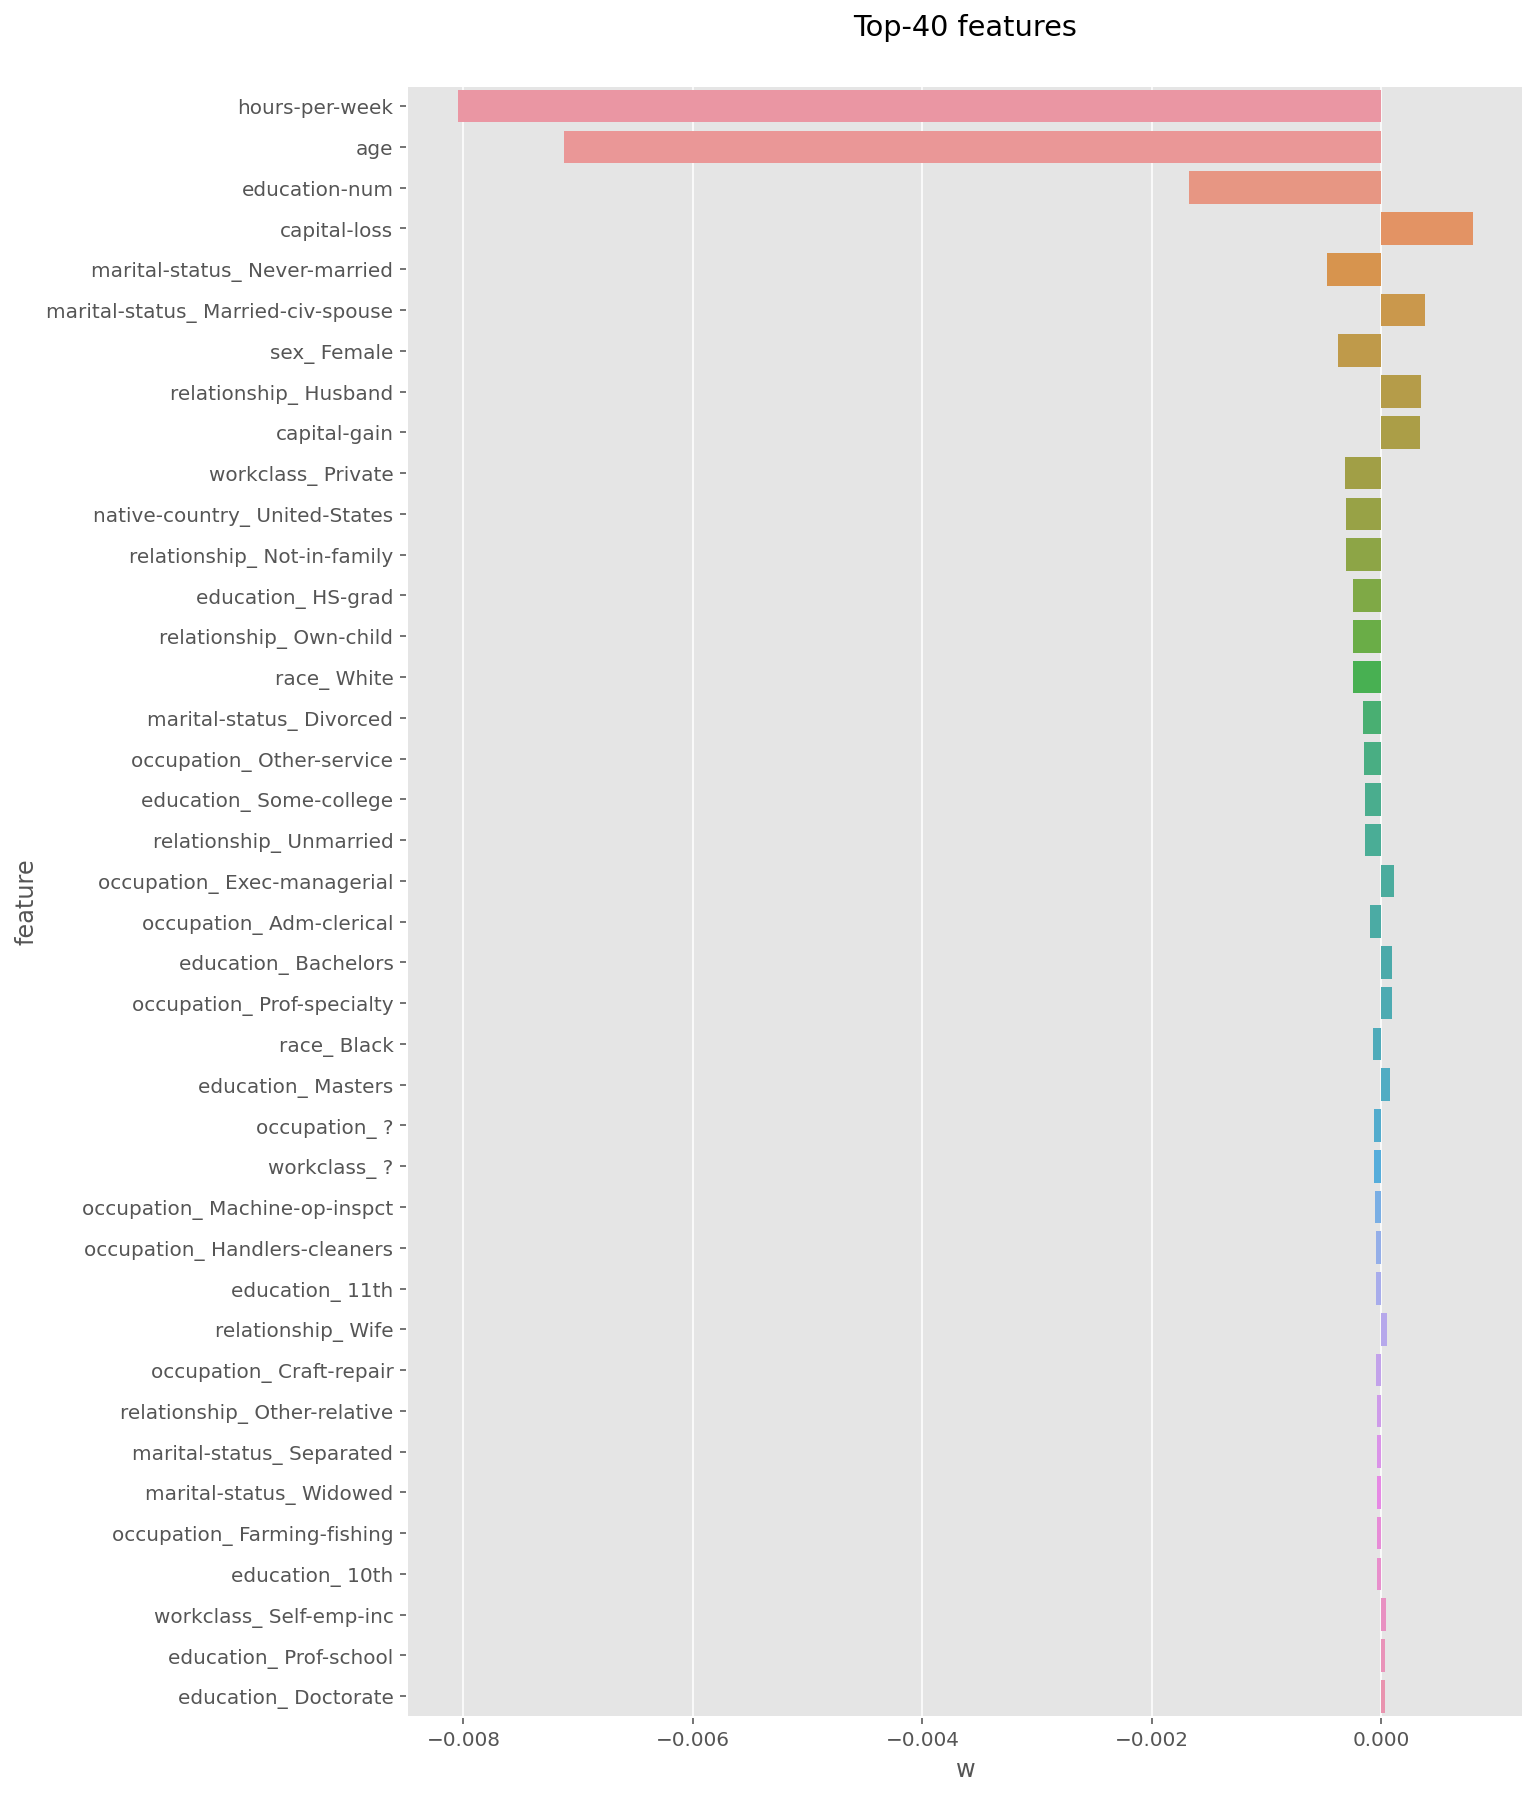

In [225]:
plt.figure(figsize=(10, 15))
sns.barplot(y=top_40.index, x=top_40.w)
plt.title('Top-40 features')
plt.show()

На графике хорошо виден разрыв между первыми 3-4 самыми важными признаками и всеми остальными (остальные существенно меньше)

Это связано, видимо, как раз с разным масштабом признаков

In [226]:
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_enc[top_40.index], y_train)
y_pred = logreg.predict_proba(X_test_enc[top_40.index])[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.75991
AP: 0.75998


In [227]:
%%time
feature_imp = pd.DataFrame({'feature': X_train_enc[top_40.index].columns, 
                            'importance': abs(logreg.coef_[0]),
                            'w': logreg.coef_[0]})
top_40 = feature_imp.sort_values('importance', ascending=False).head(40)
top_40.set_index('feature', inplace=True)#['feature']

CPU times: user 2.87 ms, sys: 934 µs, total: 3.81 ms
Wall time: 1.42 ms


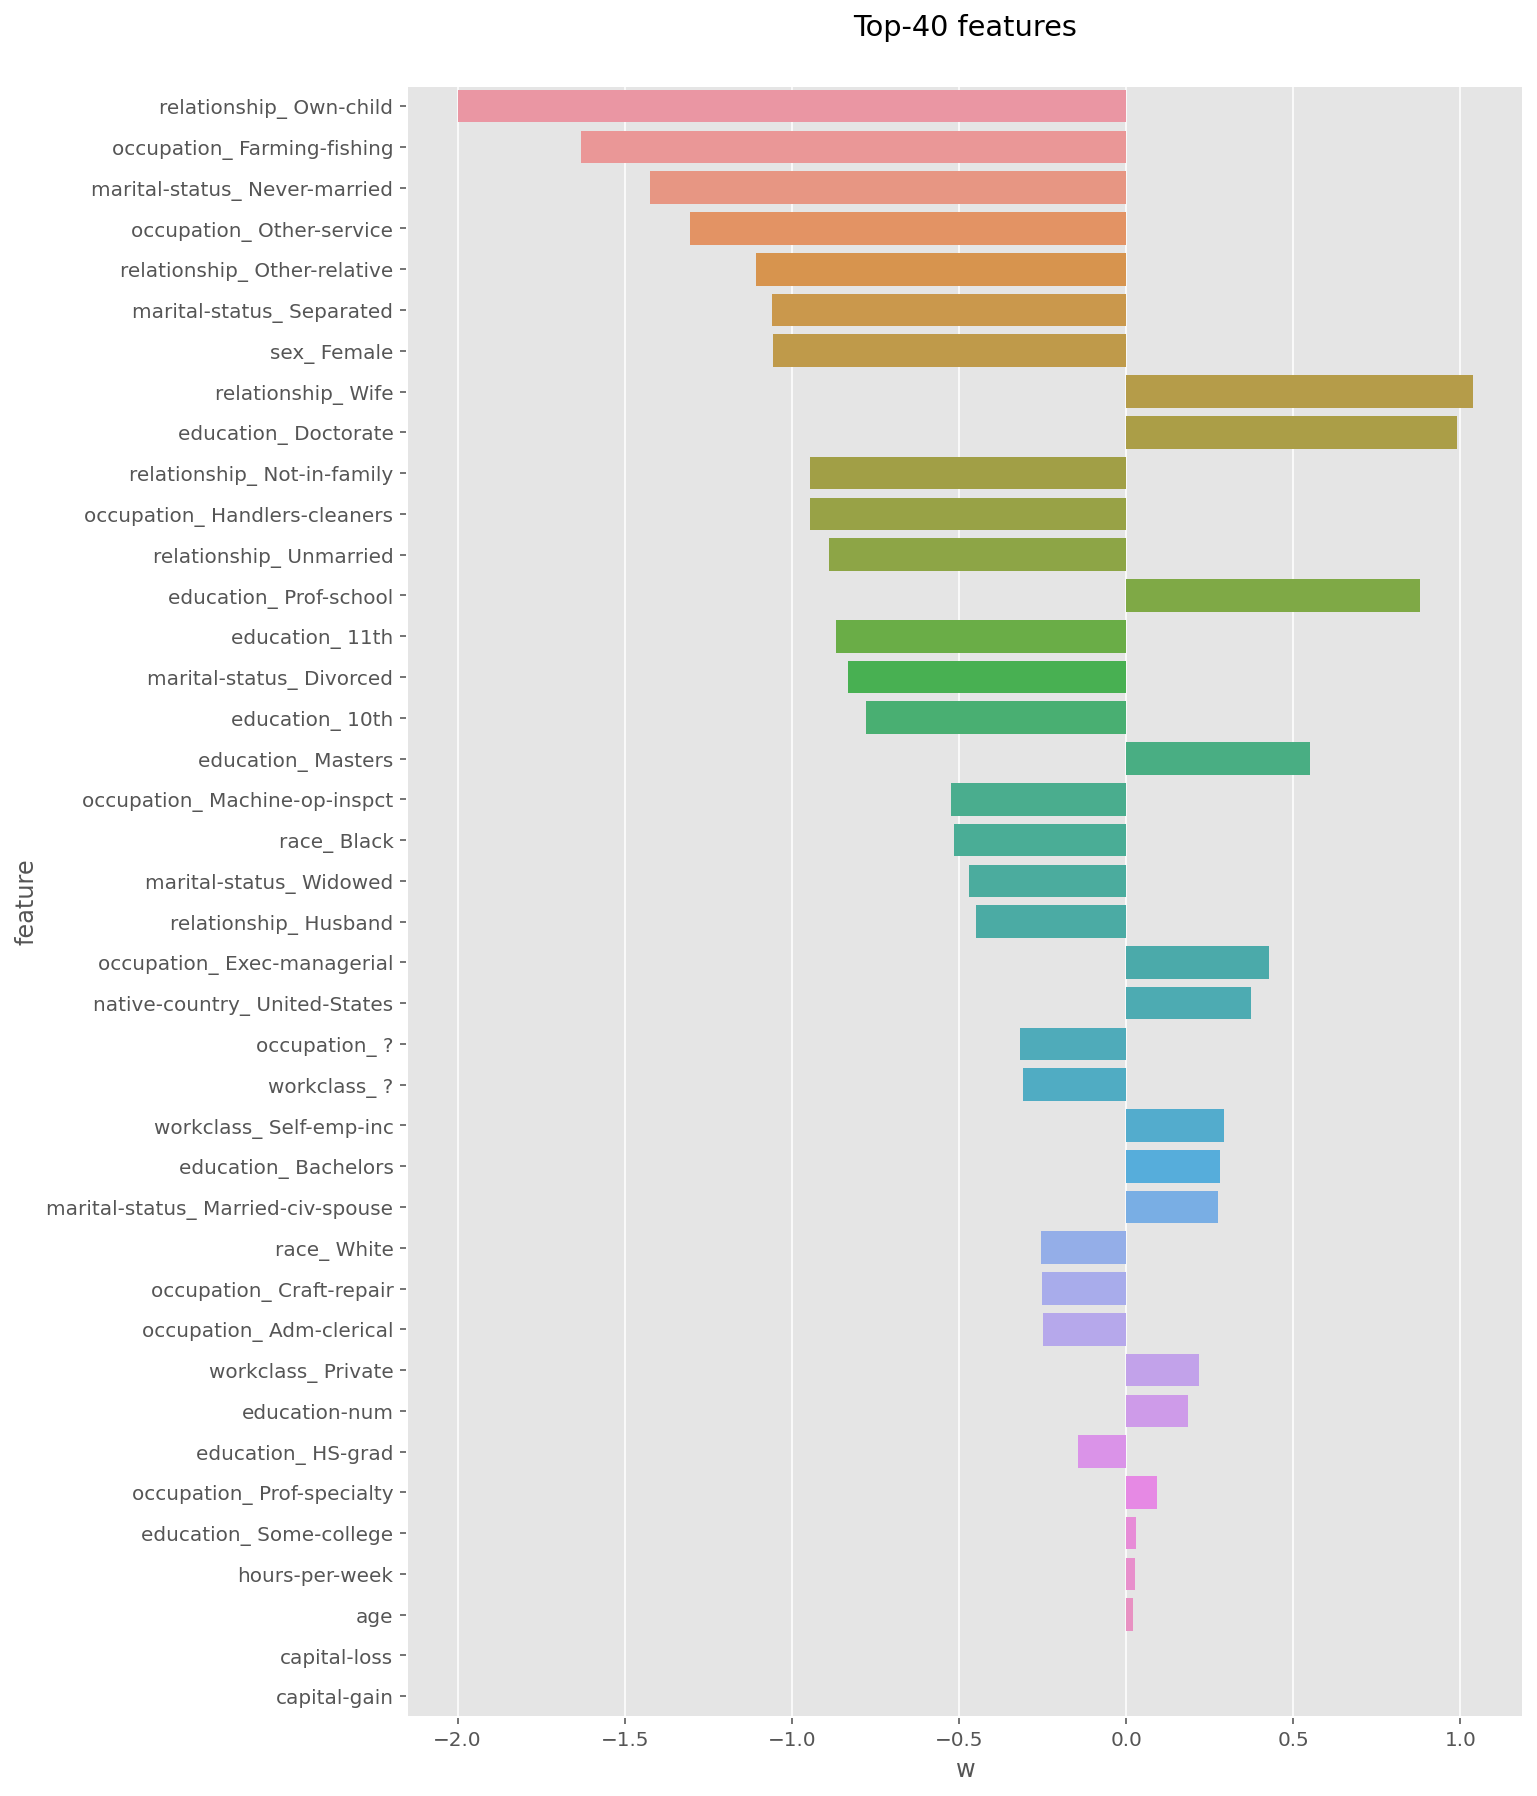

In [228]:
plt.figure(figsize=(10, 15))
sns.barplot(y=top_40.index, x=top_40.w)
plt.title('Top-40 features')
plt.show()

Получилось очень интересно... Качество до отбора признаков было низким. После отбора оно почти такое же, как и с масштабированием (и даже лучше, чем с масштабированием и отбором (!?)).

А если посмотреть на новые коэффициенты 40 отобранных фич - те, что изначально были супер значимыми (вероятно, благодаря масштабу) - `age`, `hours-per-weak` - теперь, наоборот, в самом низу списка...

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [229]:
X_train_enc = pd.get_dummies(X_train, columns=categorical)
X_test_enc = pd.get_dummies(X_test, columns=categorical)
for col in set(X_train_enc.columns) - set(X_test_enc.columns):
    X_test_enc[col] = 0
for col in set(X_test_enc.columns) - set(X_train_enc.columns):
    X_train_enc[col] = 0
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns)

s = StandardScaler().fit(X_train_enc)
X_train_enc[X_train_enc.columns] = s.transform(X_train_enc[X_train_enc.columns])
X_test_enc[X_test_enc.columns] = s.transform(X_test_enc[X_test_enc.columns])

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_enc, y_train)
y_pred = logreg.predict_proba(X_test_enc)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.76607
AP: 0.76615


In [230]:
%%time
feature_imp = pd.DataFrame({'feature': X_train_enc.columns, 
                            'importance': abs(logreg.coef_[0]),
                            'w': logreg.coef_[0]})
top_40 = feature_imp.sort_values('importance', ascending=False).head(40)
top_40.set_index('feature', inplace=True)#['feature']

CPU times: user 4.2 ms, sys: 1.97 ms, total: 6.17 ms
Wall time: 4.84 ms


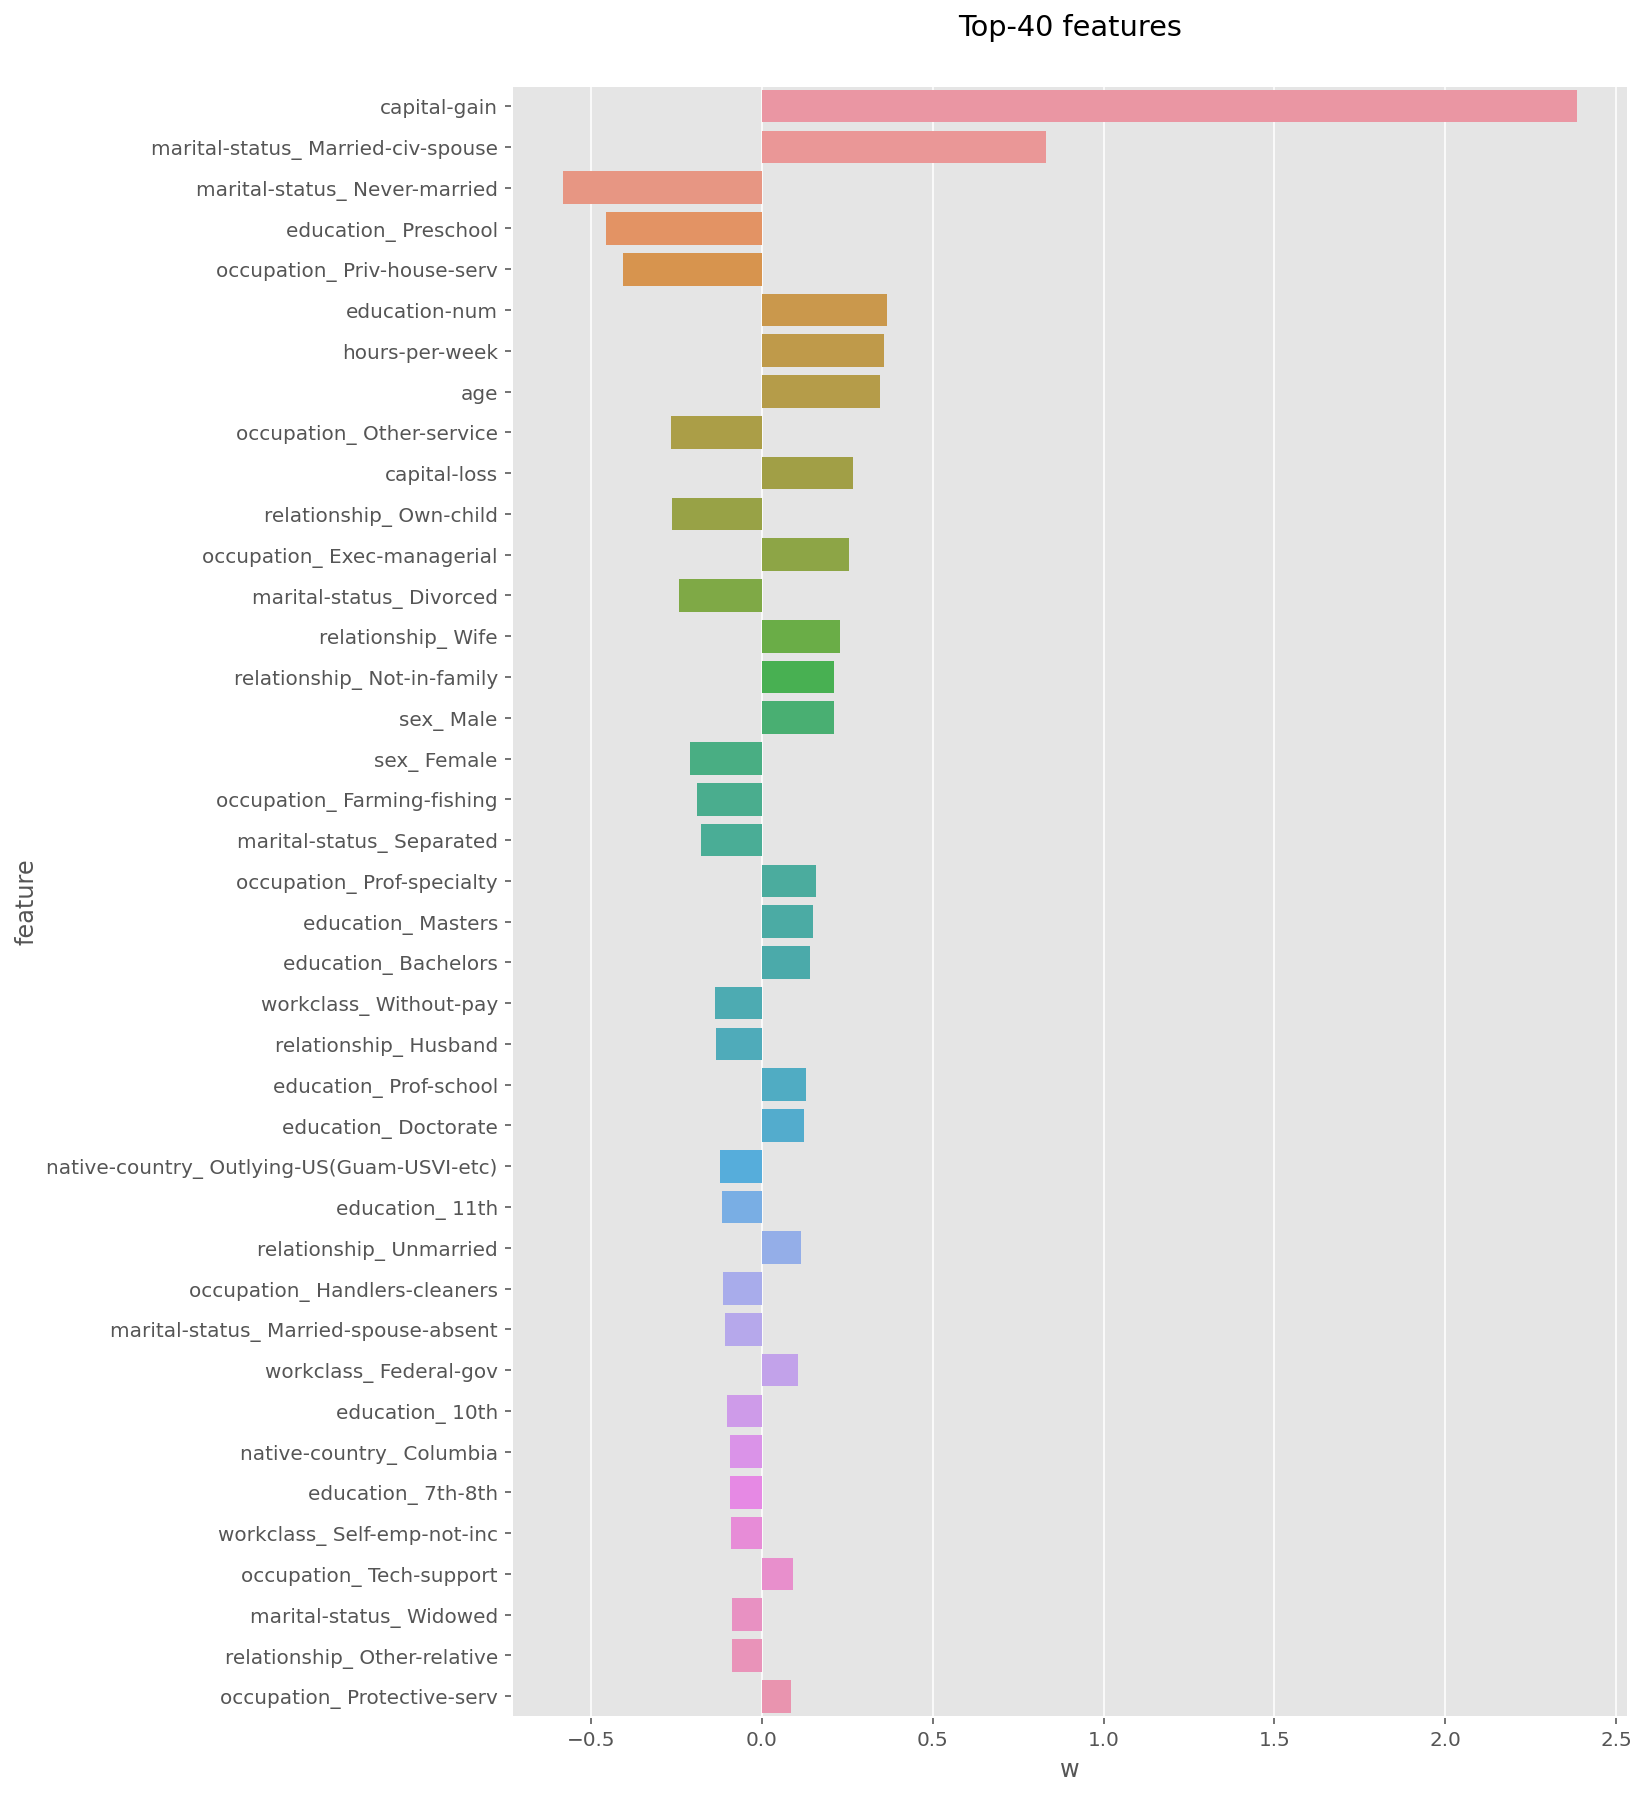

In [231]:
plt.figure(figsize=(10, 15))
sns.barplot(y=top_40.index, x=top_40.w)
plt.title('Top-40 features')
plt.show()

In [232]:
s = StandardScaler().fit(X_train_enc[top_40.index])
X_train_enc[top_40.index] = s.transform(X_train_enc[top_40.index])
X_test_enc[top_40.index] = s.transform(X_test_enc[top_40.index])

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_enc[top_40.index], y_train)
y_pred = logreg.predict_proba(X_test_enc[top_40.index])[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.76109
AP: 0.76114


Список топ-40 фич изменился (по крайней мере порядок). Но топ-2 фичей совпадают и в целом пересечений много. 

Качество упало, но совсем незначительно

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [233]:
%%time

X_train_enc = pd.get_dummies(X_train, columns=categorical)
X_test_enc = pd.get_dummies(X_test, columns=categorical)
for col in set(X_train_enc.columns) - set(X_test_enc.columns):
    X_test_enc[col] = 0
for col in set(X_test_enc.columns) - set(X_train_enc.columns):
    X_train_enc[col] = 0
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns)

enc_cols = X_train_enc.columns

# -----------
# count means diff  (numerator)
mean_diff = abs(X_train_enc[y_train == 1].mean() - X_train_enc[y_train == 0].mean())

# count vars
var_1 = X_train_enc[y_train == 1].var()
var_0 = X_train_enc[y_train == 0].var()

# n of objects in classes
n1 = y_train.value_counts()[1]
n0 = y_train.value_counts()[0]

# calculate denominator
den = np.sqrt(n1 * var_1 + n0 * var_0) / np.sqrt(n1 + n0)

feature_imp = pd.DataFrame({'feature': enc_cols, 'importance': mean_diff / den})
top_40 = feature_imp.sort_values('importance', ascending=False).head(40)
top_40.set_index('feature', inplace=True)#['feature']

CPU times: user 82.3 ms, sys: 2.4 ms, total: 84.7 ms
Wall time: 82.3 ms


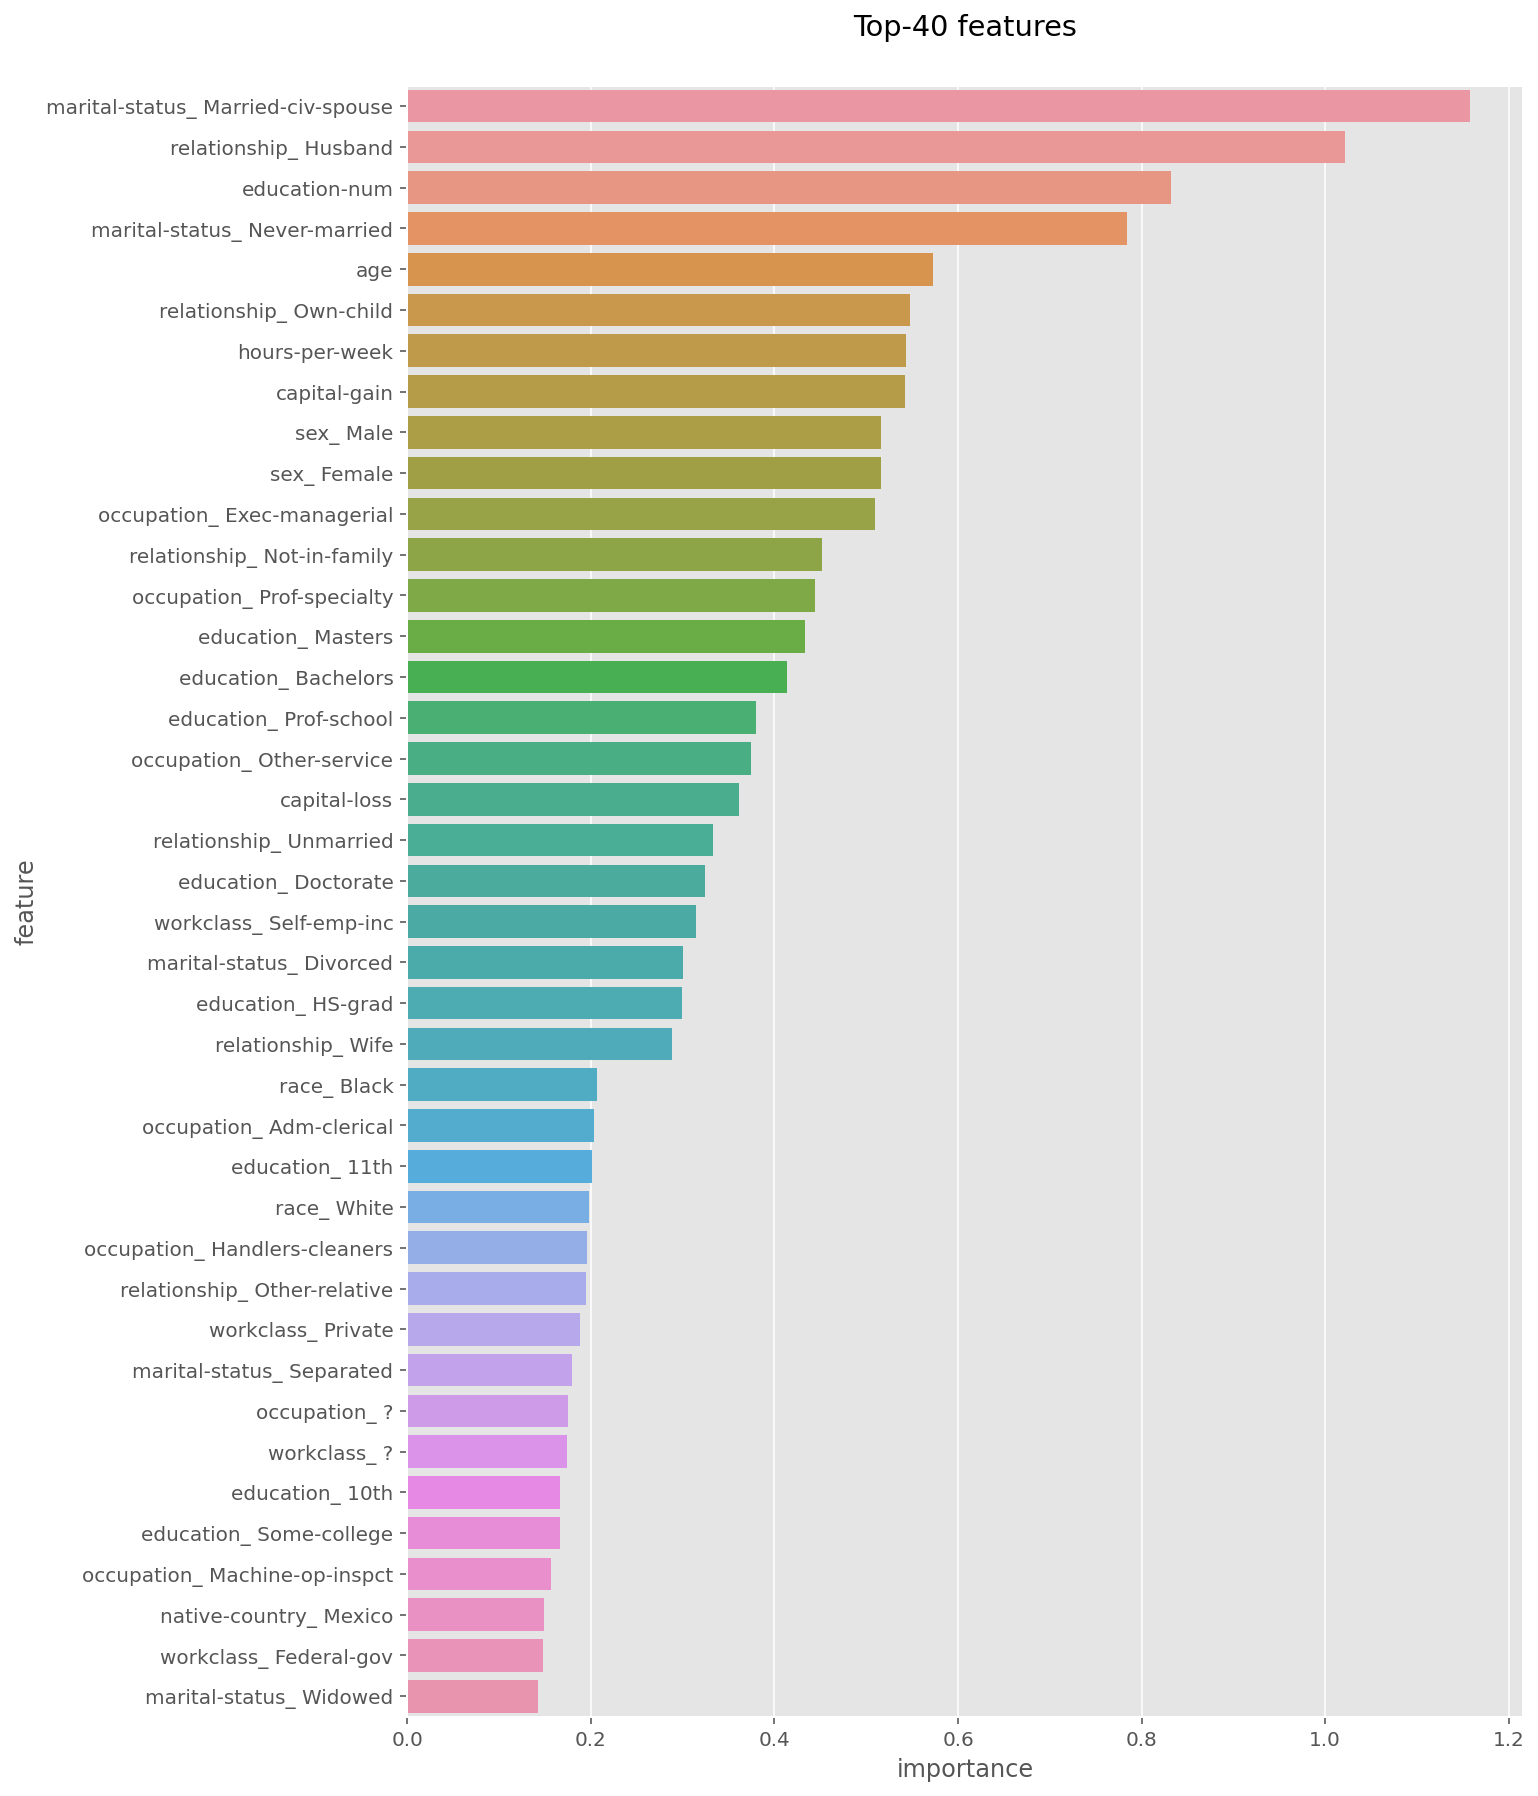

In [234]:
plt.figure(figsize=(10, 15))
sns.barplot(y=top_40.index, x=top_40.importance)
plt.title('Top-40 features')
plt.show()

In [236]:
X_train_cut = X_train_enc.loc[:, top_40.index]
X_test_cut = X_test_enc.loc[:, top_40.index]

numeric_temp = list(set(top_40.index) & set(numeric))
if len(numeric_temp) != 0:
    s = StandardScaler().fit(X_train_cut[numeric_temp])
    X_train_cut[numeric_temp] = s.transform(X_train_cut[numeric_temp])
    X_test_cut[numeric_temp] = s.transform(X_test_cut[numeric_temp])

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_cut, y_train)
y_pred = logreg.predict_proba(X_test_cut)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.76199
AP: 0.76205


Очень неплохо - качество чуть упало, но гуд

#### __Задание 11. Методы-обёртки__ (1 балл) 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

Зафиксируем качество на всех признаках

In [264]:
%%time

X_train_temp = X_train_enc.copy().loc[X_train_idx]
X_val_temp = X_train_enc.copy().loc[X_val_idx]
y_train_temp = y_train.copy().loc[X_train_idx]
y_val_temp = y_train.copy().loc[X_val_idx]

s = StandardScaler().fit(X_train_temp[numeric])
X_train_temp[numeric] = s.transform(X_train_temp[numeric])
X_val_temp[numeric] = s.transform(X_val_temp[numeric])

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_temp, y_train_temp)
y_pred = logreg.predict_proba(X_val_temp)[:, 1]

precision, recall, _ = precision_recall_curve(y_val_temp, y_pred)
baseline_score = auc(recall, precision)
print('AUC-PR: %.5f' % baseline_score)
print('AP: %.5f' % average_precision_score(y_val_temp, y_pred))

AUC-PR: 0.77338
AP: 0.77349
CPU times: user 2.52 s, sys: 606 ms, total: 3.13 s
Wall time: 607 ms


In [265]:
X_test_temp = X_test_enc.copy()
X_test_temp[numeric] = s.transform(X_test_temp[numeric])
y_pred = logreg.predict_proba(X_test_temp)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
score = auc(recall, precision)
print('AUC-PR: %.5f' % score)
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.76658
AP: 0.76665


Теперь удаляем итеративно, пока не останется 40 самых стойких пацанов

In [259]:
%%time

enc_cols = X_train_enc.columns
scores = []
for i in tqdm(range(len(enc_cols) - 40)):
    
    remove_column = ''
    worst_score = float('inf')
    best_score = float('-inf')
    for feat in enc_cols:
        tmp_cols = np.delete(enc_cols, np.where(enc_cols == feat))
        
        X_train_temp = X_train_enc.loc[X_train_idx][tmp_cols]
        X_val_temp = X_train_enc.loc[X_val_idx][tmp_cols]

        numeric_temp = list(set(X_train_temp.columns) & set(numeric))
        if len(numeric_temp) != 0:
            s = StandardScaler().fit(X_train_temp[numeric_temp])
            X_train_temp[numeric_temp] = s.transform(X_train_temp[numeric_temp])
            X_val_temp[numeric_temp] = s.transform(X_val_temp[numeric_temp])

        logreg = LogisticRegression(max_iter=10000)
        logreg.fit(X_train_temp, y_train_temp)
        y_pred = logreg.predict_proba(X_val_temp)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val_temp, y_pred)
        score = auc(recall, precision)

        if score < worst_score:
            worst_score = score
            remove_col = feat    
        if score > best_score:
            best_score = score
            
    enc_cols = np.delete(enc_cols, np.where(enc_cols == remove_col))
    scores.append(best_score)

  0%|          | 0/68 [00:00<?, ?it/s]

CPU times: user 2h 29min 54s, sys: 36min 28s, total: 3h 6min 22s
Wall time: 36min 41s


In [271]:
X_train_temp = X_train_enc.loc[:, enc_cols]
X_test_temp = X_test_enc.loc[:, enc_cols]

numeric_temp = list(set(enc_cols) & set(numeric))
if len(numeric_temp) != 0:
    s = StandardScaler().fit(X_train_temp[numeric_temp])
    X_train_temp[numeric_temp] = s.transform(X_train_temp[numeric_temp])
    X_test_temp[numeric_temp] = s.transform(X_test_temp[numeric_temp])

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_temp, y_train)
y_pred = logreg.predict_proba(X_test_temp)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
score = auc(recall, precision)
print('AUC-PR: %.5f' % score)
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.41898
AP: 0.44481


Ну мы явно выкинули очень много информации, и теперь качество сильно упало :(

Отрисуем график скоров на каждой итерации

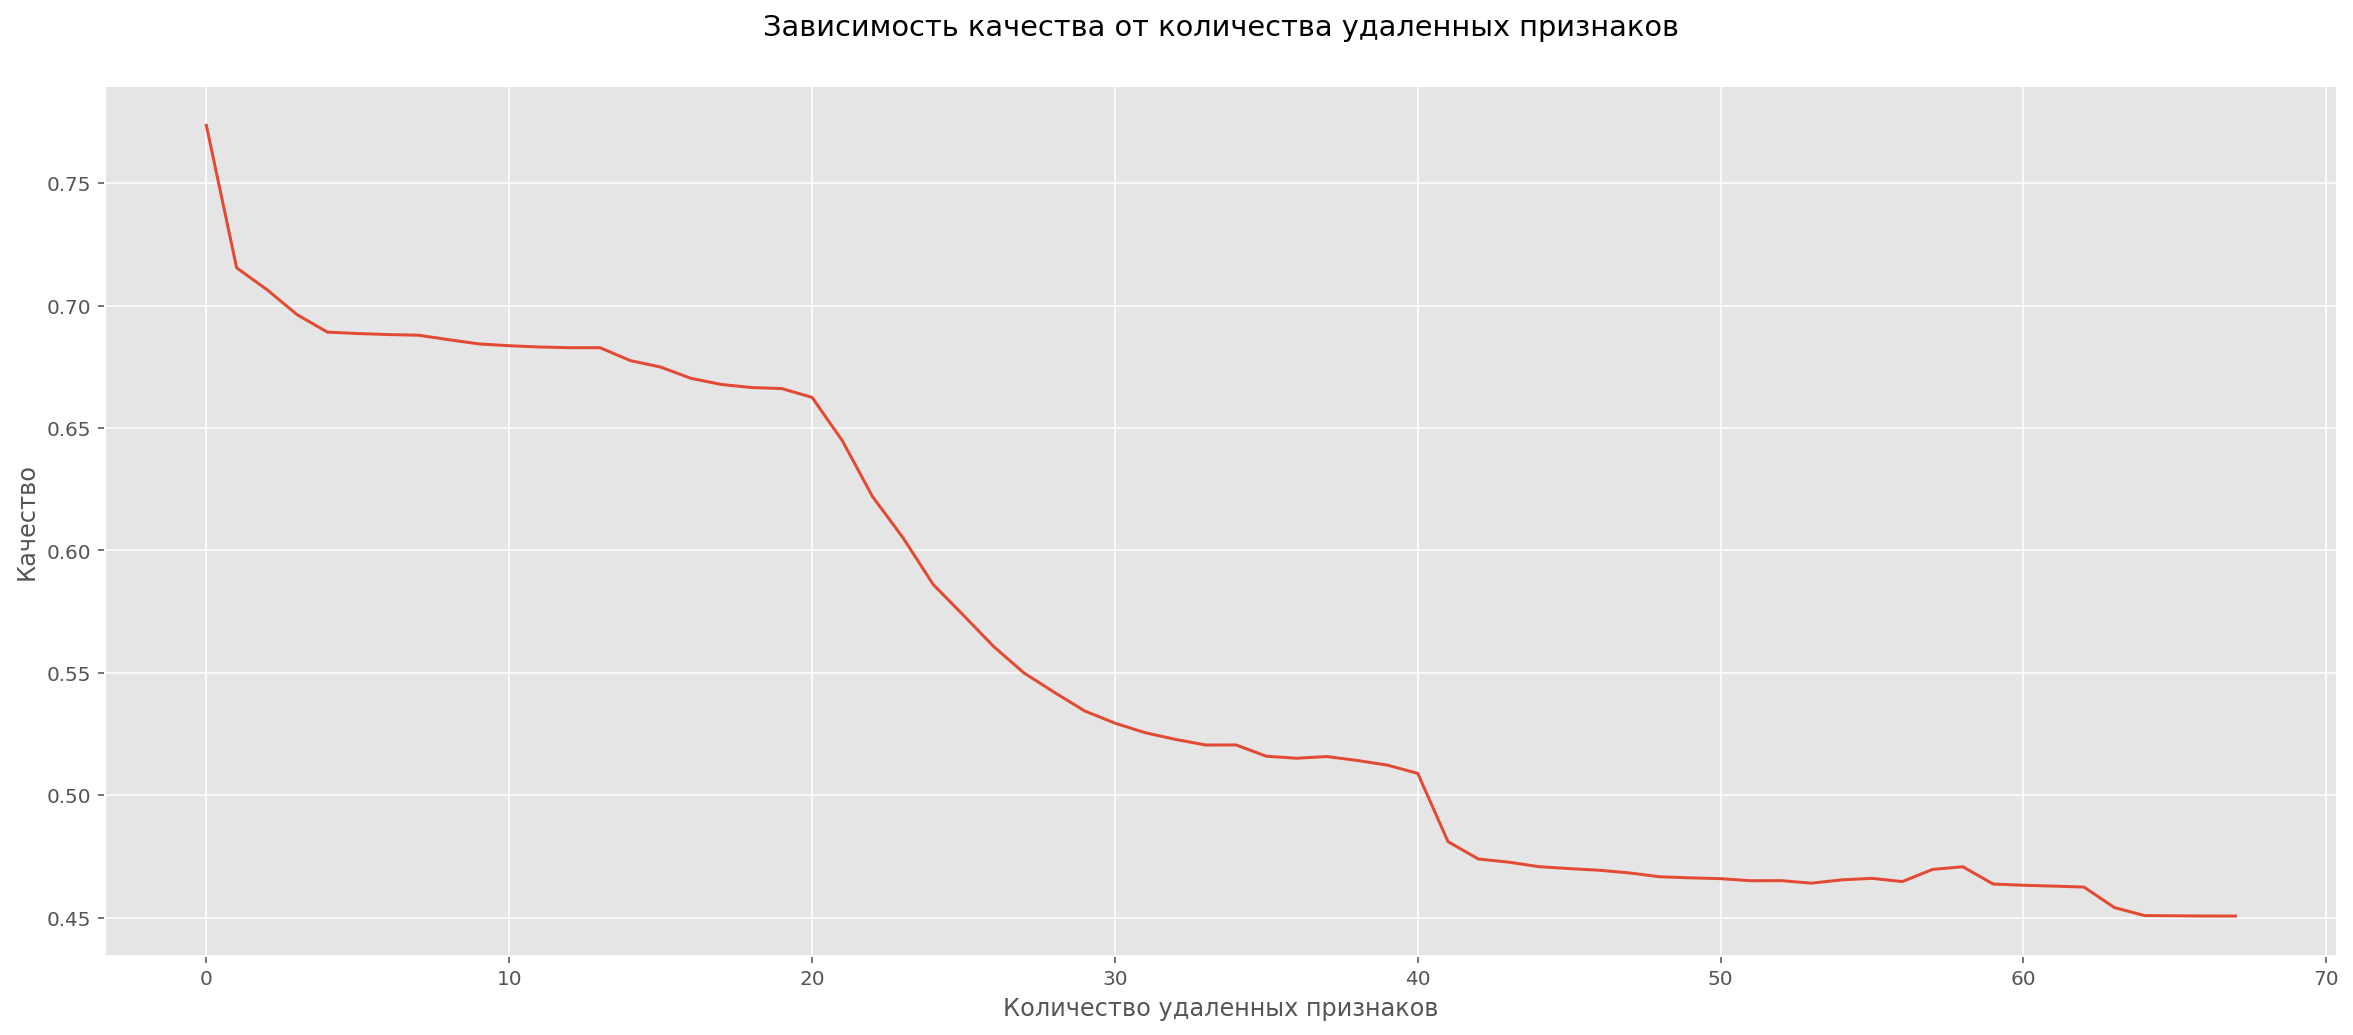

In [263]:
plt.plot(scores)
plt.title('Зависимость качества от количества удаленных признаков')
plt.xlabel('Количество удаленных признаков')
plt.ylabel('Качество')
plt.show()

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [382]:
X_train_temp = X_train_enc.copy().loc[X_train_idx]
X_val_temp = X_train_enc.copy().loc[X_val_idx]
y_train_temp = y_train.copy().loc[X_train_idx]
y_val_temp = y_train.copy().loc[X_val_idx]

In [383]:
%%time

enc_cols = X_train_enc.columns
selected_cols = []
scores = []

for i in tqdm(range(40)):
    
    best_col = np.nan
    best_score = float('-inf')
    for feat in enc_cols:

        tmp_cols = selected_cols + [feat]
        X_train_temp = X_train_enc.copy().loc[X_train_idx][tmp_cols]
        X_val_temp = X_train_enc.copy().loc[X_val_idx][tmp_cols]
        
        numeric_temp = list(set(X_train_temp.columns) & set(numeric))
        if len(numeric_temp) != 0:
            s = StandardScaler().fit(X_train_temp[numeric_temp])
            X_train_temp[numeric_temp] = s.transform(X_train_temp[numeric_temp])
            X_val_temp[numeric_temp] = s.transform(X_val_temp[numeric_temp])

        logreg = LogisticRegression(max_iter=10000)
        logreg.fit(X_train_temp, y_train_temp)
        y_pred = logreg.predict_proba(X_val_temp)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val_temp, y_pred)
        score = auc(recall, precision)

        if score > best_score:
            best_score = score
            best_col = feat
    selected_cols.append(best_col)
    enc_cols = np.delete(enc_cols, np.where(enc_cols == best_col))
    scores.append(best_score)

  0%|          | 0/40 [00:00<?, ?it/s]

CPU times: user 20min 59s, sys: 6min 16s, total: 27min 15s
Wall time: 5min 57s


In [386]:
X_train_temp = X_train_enc.loc[:, selected_cols]
X_test_temp = X_test_enc.loc[:, selected_cols]
numeric_temp = list(set(selected_cols) & set(numeric))
if len(numeric_temp) != 0:
    s = StandardScaler().fit(X_train_temp[numeric_temp])
    X_train_temp[numeric_temp] = s.transform(X_train_temp[numeric_temp])
    X_test_temp[numeric_temp] = s.transform(X_test_temp[numeric_temp])

logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_temp, y_train)
y_pred = logreg.predict_proba(X_test_temp)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
score = auc(recall, precision)
print('AUC-PR: %.5f' % score)
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.76501
AP: 0.76509


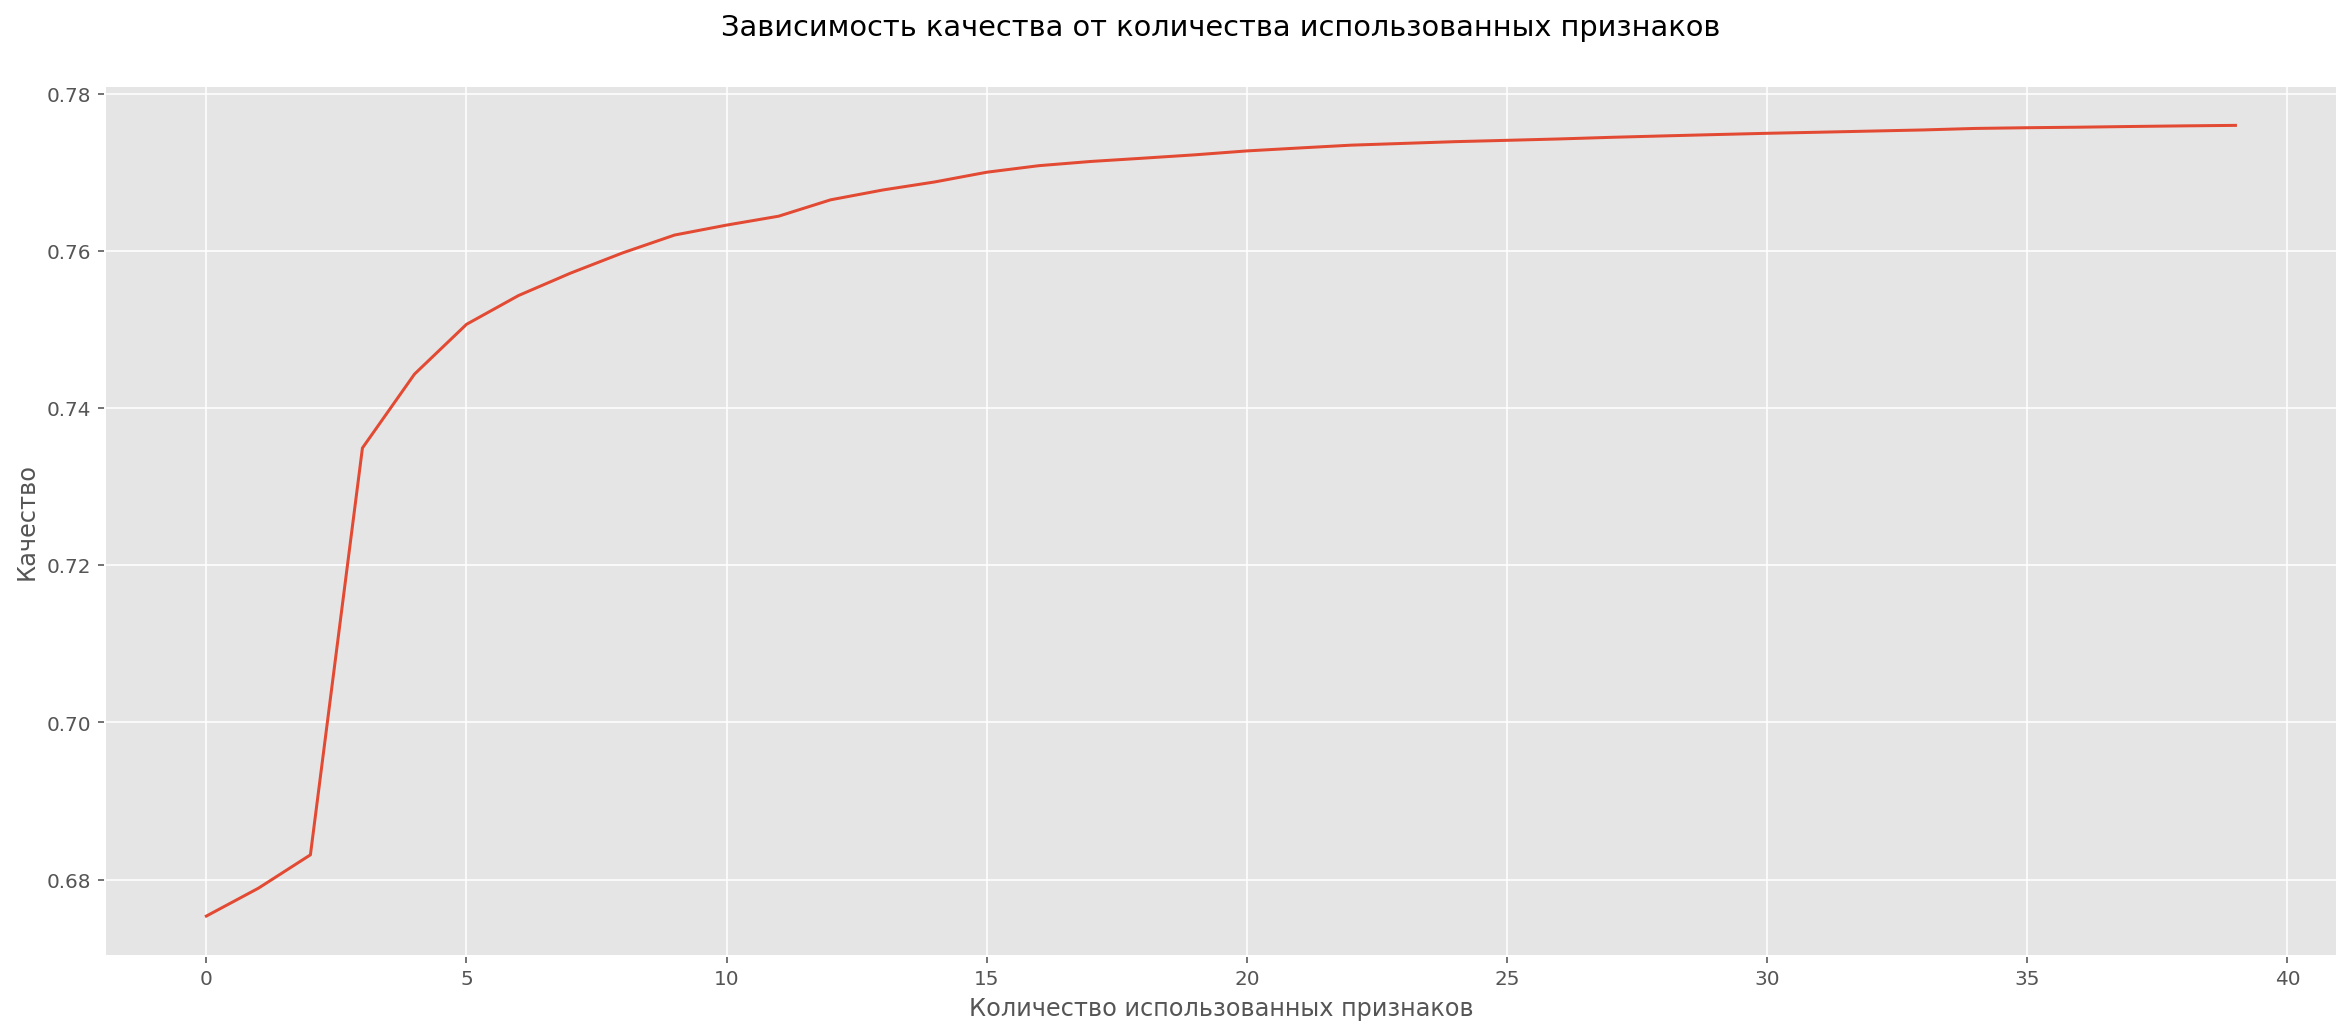

In [387]:
plt.plot(scores)
plt.title('Зависимость качества от количества использованных признаков')
plt.xlabel('Количество использованных признаков')
plt.ylabel('Качество')
plt.show()

Итеративное добавление оказалось прямо сильно лучше. 

Если удаление сработало плохо, то тут успех.

Получилось даже как-то слишком хорошо. Качество упало совсем на чуть-чуть, при этом количество признаков значительно сократилось

Начиная где-то с 30-ой фичи качество росло очень медленно. Порога, после которого бы качество только падало не нашлось, только рост

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 

Итог:

С помощью отбора признаков можно существенно сократить размерность признакового пространства, при этом не потеряв / или потеряв незначительно в качестве. 

**Отбор по весам линейной регрессии**

+
* Идет бонусом к построению модели - не нужно ничего считать дополнительно
* Быстро

-
* Нельзя забывать о нормировании признаков - иначе выйдет неадекватно
* Ловит только линейную связь - не всегда она таковая, поэтому область применения ограничена

**T-статистика**

+
* Быстро и легко посчитать
* Понятная интерпретация с точки зрения статистики 

-
* Как и многое в статистике, основано на предпосылках (например, нормальное распределение признака), что далеко не всегда совпадает с реальностью

**Отбор фичей итеративно**

+
* Основан на оценке самой модели с / без фичи - сразу можем увидеть качество
* Опять же понятный смысл - оценка объясняющей силы каждой фичи в отдельности

-
* Если убирать / добавлять признаки итеративно по одному - то зависимости между ними никак не учитываются. В случае линейных моделей - линейные зависимости = коллинеарность, а нелинейные и так не учитывались, но для других моделей это может быть важно
* Очень долго, если идти путем выкидывания признаков...


Хорошо отработало итеративное добавление фичей + по времени не так затратно, так как мы обучаемся на маленьком количестве признаков, что быстро, лишь постепенно увеличивая количество. Также хороший результат получился с t-статистикой

# Часть 4. Оценка экономического эффекта модели

> В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: 
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

> Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [285]:
# ! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
# ! unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [286]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [287]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

In [288]:
X.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed'],
      dtype='object')

In [289]:
categorical = ['job', 'marital', 'education', 'default', 
               'housing', 'loan', 'contact','month', 
               'day_of_week', 'poutcome']
numeric = ['age', 'campaign', 'pdays', 'previous',
           'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
           'euribor3m', 'nr.employed']

# categorical = X.select_dtypes('object').columns
# numeric = X.select_dtypes(np.number).columns

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [295]:
from sklearn.model_selection import KFold, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете? 
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [301]:
income = []
calls = 0
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scaling', StandardScaler(), numeric)
    ])

    pipe = Pipeline(steps=[
        ('scaling', column_transformer),
        ('logreg', LogisticRegression(max_iter=10000))
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    income.append((y_pred * y_test).sum() * 10)
    calls += y_pred.sum()
income = np.array(income)

In [302]:
print(f'Mean income: {round(income.mean(), 1)}')
print(f'Std income: {round(income.std(), 1)}')
print(f'Mean calls made: {round(calls / 5, 1)}')
print(f'Mean profit: {round((income.mean() - calls / 5), 1)}')

Mean income: 2138.0
Std income: 183.8
Mean calls made: 324.4
Mean profit: 1813.6


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [304]:
income = []
calls = 0
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scaling', StandardScaler(), numeric)
    ])

    pipe = Pipeline(steps=[
        ('scaling', column_transformer),
        ('logreg', LogisticRegression(max_iter=10000))
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    random_var = np.random.uniform(0, 20) 
    income.append((y_pred * y_test).sum() * random_var)
    calls += y_pred.sum()
income = np.array(income)

In [305]:
print(f'Mean income: {round(income.mean(), 1)}')
print(f'Std income: {round(income.std(), 1)}')
print(f'Mean calls made: {round(calls / 5, 1)}')
print(f'Mean profit: {round((income.mean() - calls / 5), 1)}')

Mean income: 1586.5
Std income: 1064.0
Mean calls made: 324.4
Mean profit: 1262.1


Внушительная дисперсия. Величина очень сильно варьируется

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [332]:
max_profit = float('-inf')
optimal_c = None

profit_means = []
profit_stds = []

for c in tqdm(np.logspace(-3, 3, 30)):
    
    profits = []
    income = []
    calls = 0
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        column_transformer = ColumnTransformer([
            ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
            ('scaling', StandardScaler(), numeric)
        ])

        pipe = Pipeline(steps=[
            ('scaling', column_transformer),
            ('logreg', LogisticRegression(C=c, max_iter=10000))
        ])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        random_var = np.random.uniform(0, 20)

        income.append((y_pred * y_test).sum() * random_var)
        calls = y_pred.sum()
        profits.append((y_pred * y_test).sum() * random_var - calls)
        
    profit_mean = np.array(profits).mean()
    profit_std = np.array(profits).std()
    
    profit_means.append(profit_mean)
    profit_stds.append(profit_std)
    
    if profit_mean > max_profit:
        optimal_c = c
        max_profit = profit_mean
    

  0%|          | 0/30 [00:00<?, ?it/s]

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [333]:
print(f'Best C: {round(optimal_c, 3)}')
print(f'Best profit: {round(max_profit, 1)}')

Best C: 0.011
Best profit: 3057.4


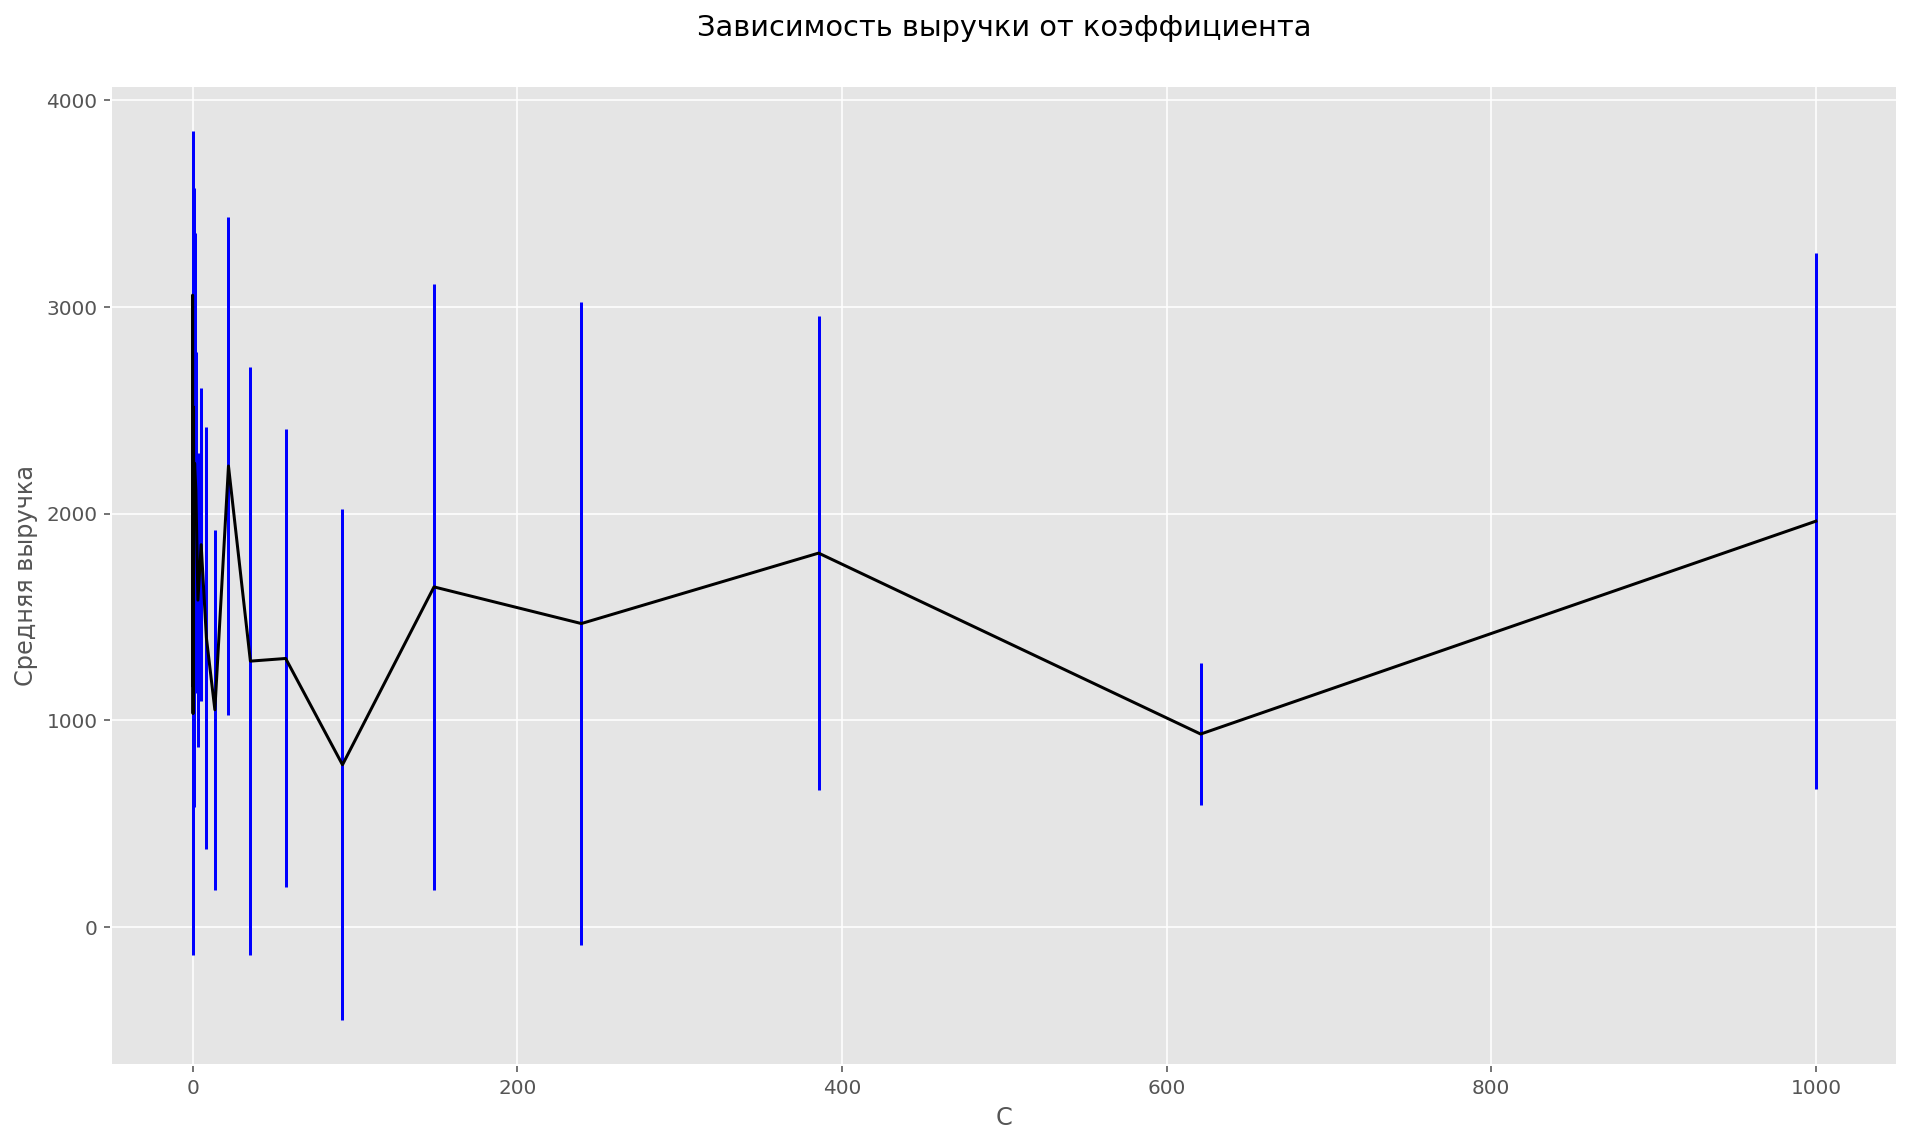

In [334]:
plt.figure(figsize=(16, 9))
plt.title('Зависимость выручки от коэффициента')
plt.xlabel('C')
plt.ylabel('Средняя выручка')
plt.errorbar(np.logspace(-3, 3, 30), profit_means, yerr=profit_stds, c='black', ecolor='blue')
plt.show()

Коэффициенты каждый раз разные, при этом разброс большой. Большую случайность вносит еще и сэмплирование оплаты из равномерного распределения от 0 до 20.

Из конкретно этого графика видно, как шатает std

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ 

`Recall`, так как звонок дешевый относительно выручки с клиента. Поэтому тут лучше лишний раз позвонить, чем потерять клиента.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [344]:
max_profit = float('-inf')
optimal_c = None
best_threshold = 0

profit_means = []
profit_stds = []

for threshold in tqdm(np.linspace(0, 1, 100)):
    profits = []
    income = []
    calls = 0
    
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        column_transformer = ColumnTransformer([
            ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
            ('scaling', StandardScaler(), numeric)
        ])

        pipe = Pipeline(steps=[
            ('scaling', column_transformer),
            ('logreg', LogisticRegression(C=c, max_iter=10000))
        ])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict_proba(X_test)[:, 1]
        y_pred = y_pred > threshold

        random_var = np.random.uniform(0, 20)

        income.append((y_pred * y_test).sum() * random_var)
        calls = y_pred.sum()
        profits.append((y_pred * y_test).sum() * random_var - calls)
        
    profit_mean = np.array(profits).mean()
    profit_std = np.array(profits).std()
    
    profit_means.append(profit_mean)
    profit_stds.append(profit_std)
    
    if profit_mean > max_profit:
        optimal_c = c
        max_profit = profit_mean
        best_threshold = threshold
    

  0%|          | 0/100 [00:00<?, ?it/s]

In [345]:
print(f'Best threshold: {round(best_threshold, 3)}')
print(f'Best profit: {round(max_profit, 1)}')

Best threshold: 0.212
Best profit: 6330.2


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

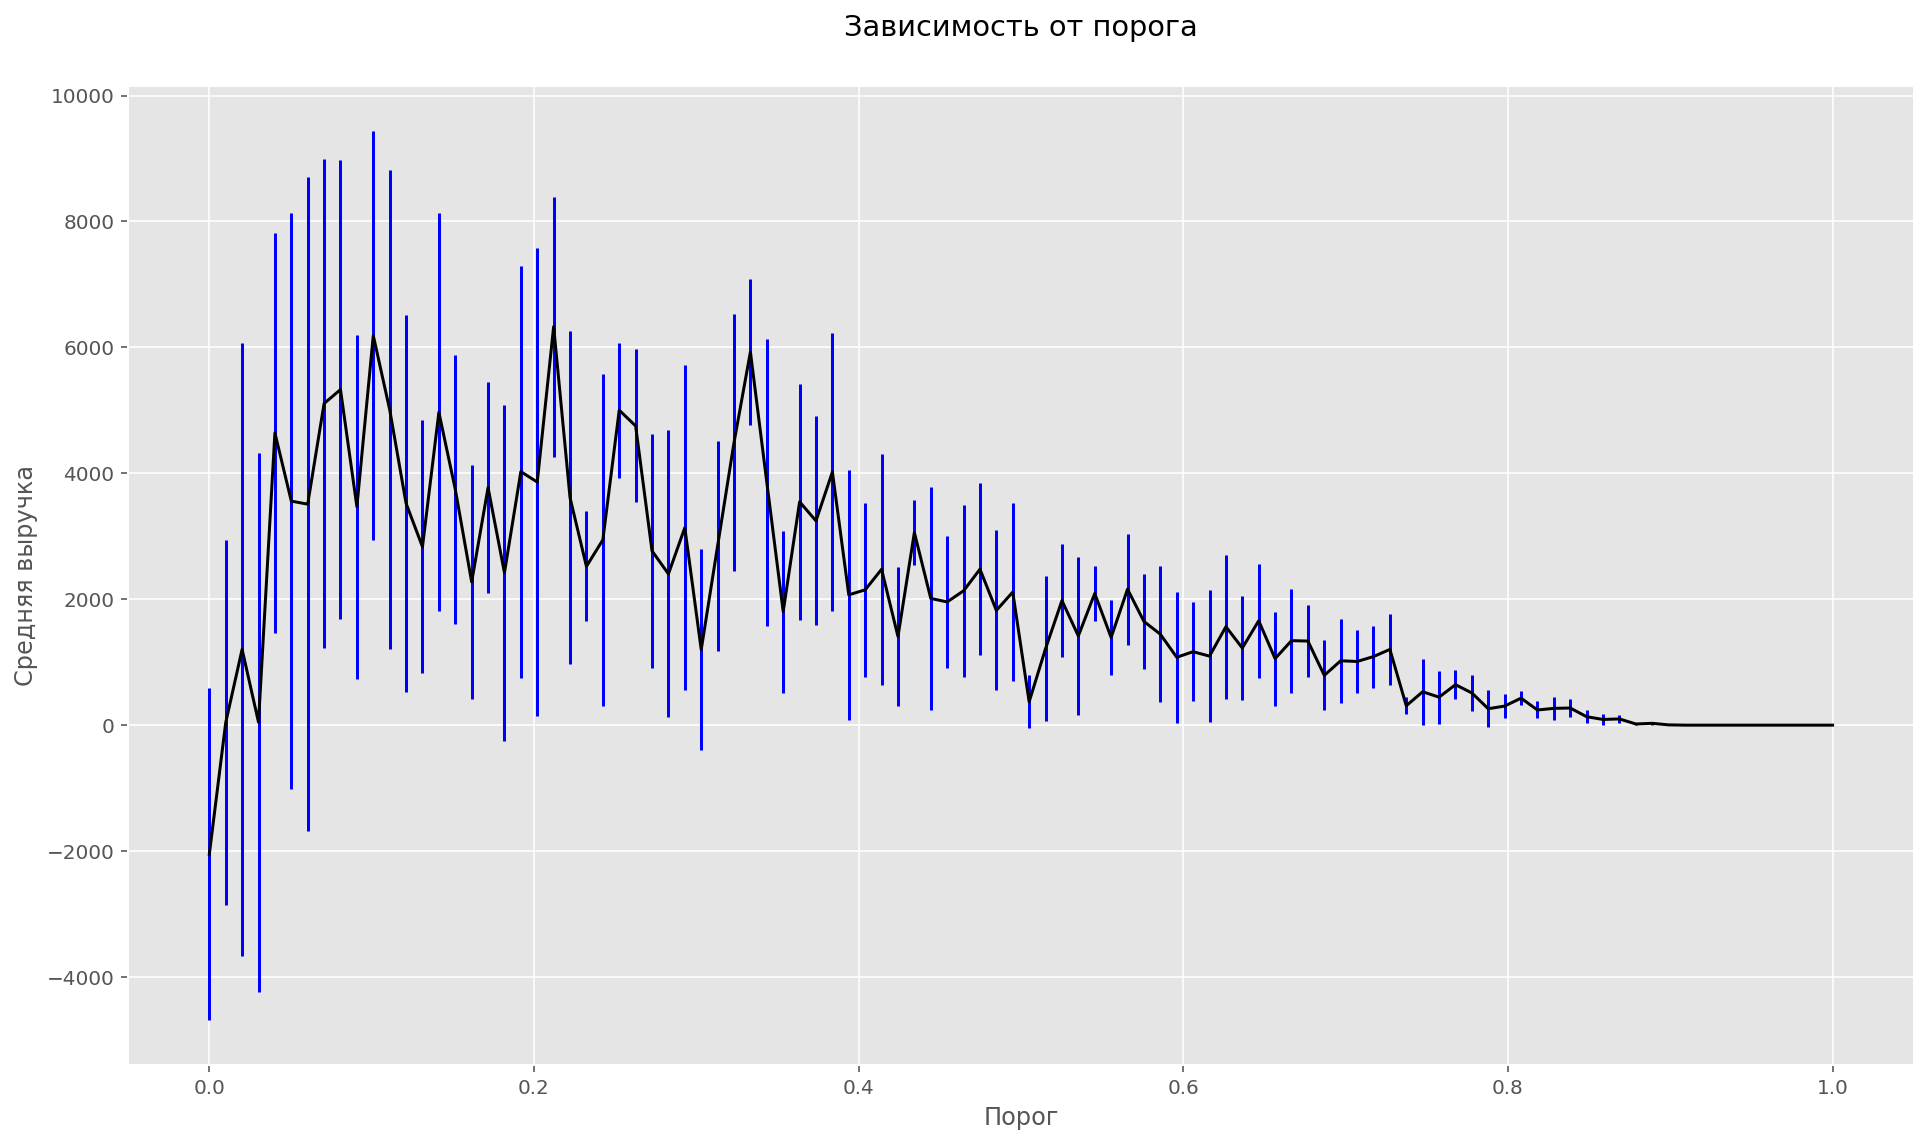

In [370]:
plt.figure(figsize=(16, 9))
plt.title('Зависимость от порога')
plt.ylabel('Средняя выручка')
plt.xlabel('Порог')
plt.errorbar(np.linspace(0, 1, 100), profit_means, yerr=profit_stds, c='black', ecolor='blue')
plt.show()

Стабильнее всего с очень высоким порогом но тогда смысла вообще нет - мы почти ничего не отлавливаем и, ожидаемо, прибыли считай нет. С низкими порогами же разброс прибыли большой, но и она сама значительно больше. Все найденные пороги находились где-то от 1 до 3, потому что с точки зрения прибыли нам важнее `Recall` (охват), поэтому при оптимизации прибыли опускаем порог, чтобы повысить `Recall` и саму прибыль соответственно, а затем уже смотрим, где сохраняется разумный баланс с `Precision`

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [347]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

In [349]:
precision = []
recall = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scaling', StandardScaler(), numeric)
    ])

    pipe = Pipeline(steps=[
        ('scaling', column_transformer),
        ('logreg', LogisticRegression(max_iter=10000))
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict_proba(X_test)[:, 1]
    y_pred = y_pred > best_threshold
    
    prec_score = precision_score(y_test, y_pred)
    rec_score = recall_score(y_test, y_pred)
    
    precision.append(prec_score)
    recall.append(rec_score) 
    
precision = np.array(precision)
recall = np.array(recall)

In [350]:
print(f'Mean precision: {round(precision.mean(), 2)}')
print(f'Mean recall: {round(recall.mean(), 2)}')
print(f'Std precision: {round(precision.std(), 2)}')
print(f'Std recall: {round(recall.std(), 2)}')

Mean precision: 0.44
Mean recall: 0.55
Std precision: 0.01
Std recall: 0.02


Получился относительный баланс. `Recall` повыше, `Precision` отстает, но терпимо.

Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

Вот это я не особо поняла :/
    
* Первый шаг ок - ясно, отобрали `Recall` >= 0.5

А дальше, не оч ясно.

В итоге я сделала следующее:

* Интерпретирую прямоугольник (это прямоугольник, отсекаемый максимально возможным `Precision` сверху. У меня - это ~0.47

* Теперь это моя новая единица, и я нормирую исходный `auc`  (~0.45) на ~0.47, чтобы получить новую площадь под кривой, исходя из того, что вся возможная площадь у меня ~0.47, а не 1 (???).

* Получаю новое значение: 0.45 / 0.47 ~ 0.96


Я без понятия, норм ли это, но шо есть, то есть :/

In [351]:
import warnings
warnings.filterwarnings('ignore')

In [354]:
precision_means = []
recall_means = []
thresholds = np.linspace(0, 1, 100)
for threshold in tqdm(thresholds):
    precision_fold = []
    recall_fold = []
    probas_fold = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        column_transformer = ColumnTransformer([
            ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
            ('scaling', StandardScaler(), numeric)
        ])

        pipe = Pipeline(steps=[
            ('scaling', column_transformer),
            ('logreg', LogisticRegression(C=c, max_iter=10000))
        ])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict_proba(X_test)[:, 1]
        y_pred = y_pred > threshold
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision_fold.append(precision)
        recall_fold.append(recall)

    precision_mean = np.array(precision_fold).mean()
    recall_mean = np.array(recall_fold).mean()   
    precision_means.append(precision_mean)
    recall_means.append(recall_mean)
    

  0%|          | 0/100 [00:00<?, ?it/s]

Берем усредненные по фолдам `Precision` и `Recall`, фильтруя по условию, что `Recall` >= 0.5

In [356]:
recall_means = np.array(recall_means)
precision_means = np.array(precision_means)

In [357]:
sel_recalls = recall_means[np.argwhere(recall_means>=0.5)]
sel_precs = precision_means[np.argwhere(recall_means>=0.5)]
sel_thresholds = thresholds[np.argwhere(recall_means>=0.5)]

# это будет верхняя линия прямоугольника = его площадь, если отсекаем прямоугольник сверху
print(f"Максимальный precision: {sel_precs.max()}")

Максимальный precision: 0.46504869607081745


Разделим на обучающую и тестовую выборку и обучим классификатор

In [363]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=777, 
                                                    stratify=y)

In [367]:
column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('scaling', StandardScaler(), numeric)
    ])

pipe = Pipeline(steps=[
        ('scaling', column_transformer),
        ('logreg', LogisticRegression(max_iter=10000))
    ])

pipe.fit(X_train, y_train)
y_pred = pipe.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
score = auc(recall, precision)
print('AUC-PR: %.5f' % score)
print('AP: %.5f' % average_precision_score(y_test, y_pred))

AUC-PR: 0.44730
AP: 0.44783


Теперь полученную метрику отнормируем на площадь прямоугольника, отсеченного максимальным значением `Precision`, чтобы получить значение метрики, если считать этот прямоугольник за единичный квадрат

In [369]:
print(f"New score: {round(score/sel_precs.max(), 2)}")

New score: 0.96
